In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
! pip install seaborn==0.12.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
sns.__version__

'0.12.0'

In [4]:
pd.__version__

'1.3.4'

In [5]:
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240527/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Cat", "Chicken", "Chinese rufous horseshoe bat", "Ferret", "Gray wolf", "Horshoe bat", "Human", "Pig"]

In [6]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)

In [7]:
def get_perturbation_output(perturbation_processed_output_dir):
    perturbation_output_files = os.listdir(perturbation_processed_output_dir)
    print(f"Number of perturbation output files = {len(perturbation_output_files)}")

    perturbed_output_dfs = []
    for perturbation_output_file in perturbation_output_files:
        df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
        orig_seq_df = df[df["orig_token"] == df["new_token"]]
        orig_pred_val = orig_seq_df[human_label].values[0]
        orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]
        
        df[pred_diff_col] = df[human_label] - orig_pred_val
        df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
        df["orig_y_pred"] = orig_pred_class
        df["new_y_pred"] = df[classes].idxmax(axis=1)
        perturbed_output_dfs.append(df)
    return pd.concat(perturbed_output_dfs)

In [8]:
def get_distribution_df(df, orig_token, perturb_pos, perturbation_id, perturbation_id_label):
    print(f"Perturbation id = {perturbation_id}")
    # perturbation df
    perturbation_df = df[df["perturbation_id"] == perturbation_id].copy()
    perturbation_df.loc[:, "type"] = "mutation"
    perturbation_id_x = perturbation_id[:-1]
    perturbation_id_x += "X"
    print(perturbation_id_x)
    # not perturbation df: all other perturbations in all sequences
#     non_perturbation_df = df[df["perturbation_id"] != perturbation_id].copy()
#     non_perturbation_df.loc[:, "type"] = "all seq, all non-mutatn perturbatns"
    perturbation_id_x_df = df[df["perturbation_id"] == perturbation_id_x].copy()
    perturbation_id_x_df["type"] = "mutation w/ new token = X"
    # all other perturbations in the same position in all sequences
    pos_non_perturbation_df = df[(df["perturb_seq_pos"] == perturb_pos) &
                                 (df["perturbation_id"] != perturbation_id_x) &
                                 (df["perturbation_id"] != perturbation_id)].copy()
    pos_non_perturbation_df.loc[:, "type"] = "all seq, same pos non-mutation perturbations"
    
    # sequences with original token
    sequence_w_orig_token_df = df[(df["orig_token"] == orig_token) & (df["perturb_seq_pos"] == perturb_pos)].copy()
    sequence_w_orig_token_ids = list(sequence_w_orig_token_df["uniref90_id"].unique())
    
    # all other perturbations in sequences with original token
#     swo_non_perturbation_df = non_perturbation_df[non_perturbation_df["uniref90_id"].isin(sequence_w_orig_token_ids)].copy()
#     swo_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, all non-mutatn perturbatns"
    
    # all other perturbations in the same positions in sequences with the original token
    swo_pos_non_perturbation_df = sequence_w_orig_token_df[(sequence_w_orig_token_df["perturbation_id"] != perturbation_id) &
                                                           (sequence_w_orig_token_df["new_token"] != "X")].copy()
    swo_pos_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, same pos non-mutation perturbations"
    
#     print(f"perturbation = {perturbation_df.shape}")
#     print(f"all seq, all non-perturbations = {non_perturbation_df.shape}")
#     print(f"all seq, same pos non-perturbations = {pos_non_perturbation_df.shape}")
#     print(f"sequence_w_orig_token_df = {sequence_w_orig_token_df.shape}")
#     print(f"seq w/ orig token, all non-perturbations = {swo_non_perturbation_df.shape}")
#     print(f"seq w/ orig token, same pos non-perturbations = {swo_pos_non_perturbation_df.shape}")
    
    # result_df = pd.concat([perturbation_df, non_perturbation_df, pos_non_perturbation_df, swo_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df = pd.concat([perturbation_df, perturbation_id_x_df, pos_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df["label"] = perturbation_id_label
    return result_df

In [9]:
perturbed_output_df = get_perturbation_output(perturbation_processed_output_dir)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

Number of perturbation output files = 94
perturbed_output_df shape = (2978369, 17)


In [10]:
perturbed_output_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred
0,2.165000e-08,0.000160,0.041796,8.639770e-07,0.000035,0.022587,0.935221,0.000200,UniRef90_A0A7U3DWG5,Human,C,479,Z,-0.000510,0.000510,Human,Human
1,2.359627e-08,0.000169,0.044200,9.430855e-07,0.000038,0.024507,0.930868,0.000216,UniRef90_A0A7U3DWG5,Human,C,1249,W,-0.004863,0.004863,Human,Human
2,2.105343e-08,0.000159,0.041455,8.435257e-07,0.000035,0.022426,0.935728,0.000197,UniRef90_A0A7U3DWG5,Human,G,549,Z,-0.000003,0.000003,Human,Human
3,2.011782e-08,0.000156,0.041621,8.157819e-07,0.000033,0.022530,0.935466,0.000194,UniRef90_A0A7U3DWG5,Human,L,116,P,-0.000265,0.000265,Human,Human
4,2.174704e-08,0.000162,0.043767,8.793120e-07,0.000036,0.024250,0.931577,0.000206,UniRef90_A0A7U3DWG5,Human,N,1186,E,-0.004154,0.004154,Human,Human
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31596,1.613479e-07,0.000151,0.033629,5.650883e-06,0.000040,0.008505,0.957051,0.000619,UniRef90_A0A8B1JFM7,Human,L,0,L,0.000000,0.000000,Human,Human
31597,1.422294e-07,0.000158,0.032334,4.948179e-06,0.000039,0.008488,0.958406,0.000569,UniRef90_A0A8B1JFM7,Human,T,1150,Y,0.001356,0.001356,Human,Human
31598,1.631860e-07,0.000147,0.034530,5.817849e-06,0.000039,0.008727,0.955913,0.000638,UniRef90_A0A8B1JFM7,Human,G,1257,P,-0.001138,0.001138,Human,Human
31599,1.622588e-07,0.000148,0.033353,5.662248e-06,0.000039,0.008349,0.957492,0.000613,UniRef90_A0A8B1JFM7,Human,V,1258,D,0.000442,0.000442,Human,Human


In [11]:
sarscov2_ids = perturbed_output_df["uniref90_id"].unique()
len(sarscov2_ids)

94

#### Alignment w.r.t WIV04 reference sequence

In [12]:
coronaviridae_alignment_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniref/alignment/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
coronaviridae_alignment_df = pd.read_csv(coronaviridae_alignment_file_path)
sarscov2_alignment_df = coronaviridae_alignment_df[coronaviridae_alignment_df["uniref90_id"].isin(sarscov2_ids)]
sarscov2_alignment_df

,uniref90_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens
1,UniRef90_A0A7U3RIT3,--------------MFVFLVLVPLVSS--------Q----------...,MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus 2,homo sapiens,homo sapiens
2,UniRef90_A0A7U3HGG2,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus 2,homo sapiens,homo sapiens
3,UniRef90_A0A7U3EEN6,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus 2,homo sapiens,homo sapiens
4,UniRef90_A0A7U3HDM5,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus 2,homo sapiens,homo sapiens
...,...,...,...,...,...,...
89,UniRef90_A0A8B1JFB8,---------------------LPLVSS--------Q----------...,LPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQD...,Severe acute respiratory syndrome coronavirus 2,homo sapiens,homo sapiens
90,UniRef90_A0A8B6RCH8,----------------------------------------------...,GVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFD...,Severe acute respiratory syndrome coronavirus 2,homo sapiens,homo sapiens
91,UniRef90_A0A895ZLB7,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus 2,homo sapiens,homo sapiens
92,UniRef90_A0A8B1JCD7,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTIRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus 2,homo sapiens,homo sapiens


#### WIV04 alignment mapping

In [13]:
wiv04_df = sarscov2_alignment_df[sarscov2_alignment_df["uniref90_id"] == "WIV04"]
wiv04_df["aligned_seq"].values[0]

'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [14]:
sarscov2_alignment_df[sarscov2_alignment_df["uniref90_id"] == "UniRef90_A0A8B1JFB8"]["seq"].values[0]

'LPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNYPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNEXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSXXXXXXXXXXXXXXXXXXTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRXXXXXXXXXXX

In [15]:
sarscov2_alignment_df[sarscov2_alignment_df["uniref90_id"] == "UniRef90_A0A8B1JFB8"]["aligned_seq"].values[0]

'---------------------LPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNYPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTA--------------------------------------------------GAA------AYYVGYLQPRTFLLKYNEXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--XXXXPNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SXXXX----XXXXXX--------------------------------XXXXXXXX-------

In [16]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
print(wiv04_aligned_seq)
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
# perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)        
# perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")

--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP--------

### Alignment mapping of all other sequences

In [17]:
perturbed_output_dfs = []
for _, row in sarscov2_alignment_df.iterrows():
    alignment_mapping_seqpos_pos = {}
    aligned_seq = row["aligned_seq"]
    pos = 0
    for i, token in enumerate(aligned_seq):
        if token == "-":
            continue
        else:
            pos += 1
            alignment_mapping_seqpos_pos[pos] = i
    df = perturbed_output_df[perturbed_output_df["uniref90_id"] == row["uniref90_id"]].copy()
    df["perturb_seq_pos"] = df["perturb_pos"].apply(lambda x: wiv04_position_mapping[alignment_mapping_seqpos_pos[x+1]] 
                                                    if alignment_mapping_seqpos_pos[x+1] in wiv04_position_mapping else None)
    perturbed_output_dfs.append(df)

In [18]:
perturbed_output_df = pd.concat(perturbed_output_dfs)
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")
perturbed_output_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
0,3.646653e-08,0.000455,0.282759,0.000003,0.000108,0.318339,0.396981,0.001354,WIV04,Human,K,1037,J,-0.190584,0.190584,Human,Human,1038
1,2.361889e-08,0.000448,0.208778,0.000002,0.000094,0.221644,0.568144,0.000890,WIV04,Human,P,1111,W,-0.019422,0.019422,Human,Human,1112
2,2.533365e-08,0.000429,0.207266,0.000002,0.000088,0.210399,0.580933,0.000882,WIV04,Human,S,874,V,-0.006632,0.006632,Human,Human,875
3,2.377062e-08,0.000423,0.204186,0.000002,0.000085,0.206074,0.588371,0.000860,WIV04,Human,E,308,J,0.000806,0.000806,Human,Human,309
4,2.991777e-08,0.000481,0.211196,0.000002,0.000102,0.217975,0.569302,0.000942,WIV04,Human,K,1148,M,-0.018263,0.018263,Human,Human,1149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31596,1.613479e-07,0.000151,0.033629,0.000006,0.000040,0.008505,0.957051,0.000619,UniRef90_A0A8B1JFM7,Human,L,0,L,0.000000,0.000000,Human,Human,10
31597,1.422294e-07,0.000158,0.032334,0.000005,0.000039,0.008488,0.958406,0.000569,UniRef90_A0A8B1JFM7,Human,T,1150,Y,0.001356,0.001356,Human,Human,1160
31598,1.631860e-07,0.000147,0.034530,0.000006,0.000039,0.008727,0.955913,0.000638,UniRef90_A0A8B1JFM7,Human,G,1257,P,-0.001138,0.001138,Human,Human,1267
31599,1.622588e-07,0.000148,0.033353,0.000006,0.000039,0.008349,0.957492,0.000613,UniRef90_A0A8B1JFM7,Human,V,1258,D,0.000442,0.000442,Human,Human,1268


In [19]:
perturbed_output_df[perturbed_output_df["uniref90_id"] == "UniRef90_A0A8B1JFB8"].sort_values("perturb_pos")

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
4851,1.831830e-07,0.000277,0.066953,0.000007,0.000069,0.026557,0.905197,0.000940,UniRef90_A0A8B1JFB8,Human,L,0,D,-0.005334,0.005334,Human,Human,8
19012,1.611156e-07,0.000268,0.059106,0.000006,0.000062,0.022489,0.917272,0.000798,UniRef90_A0A8B1JFB8,Human,L,0,C,0.006741,0.006741,Human,Human,8
22445,1.692677e-07,0.000266,0.063550,0.000006,0.000064,0.024717,0.910531,0.000864,UniRef90_A0A8B1JFB8,Human,L,0,L,0.000000,0.000000,Human,Human,8
14415,1.861478e-07,0.000276,0.065850,0.000007,0.000069,0.025757,0.907092,0.000948,UniRef90_A0A8B1JFB8,Human,L,0,R,-0.003439,0.003439,Human,Human,8
14335,1.273651e-07,0.000267,0.058968,0.000005,0.000056,0.022653,0.917385,0.000667,UniRef90_A0A8B1JFB8,Human,L,0,Y,0.006854,0.006854,Human,Human,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30389,1.666995e-07,0.000267,0.064752,0.000006,0.000065,0.025571,0.908475,0.000864,UniRef90_A0A8B1JFB8,Human,T,1265,R,-0.002056,0.002056,Human,Human,1273
17368,1.654762e-07,0.000266,0.063155,0.000006,0.000064,0.024660,0.910999,0.000850,UniRef90_A0A8B1JFB8,Human,T,1265,U,0.000467,0.000467,Human,Human,1273
13300,1.654733e-07,0.000266,0.063158,0.000006,0.000064,0.024661,0.910995,0.000850,UniRef90_A0A8B1JFB8,Human,T,1265,O,0.000464,0.000464,Human,Human,1273
1319,1.654764e-07,0.000266,0.063157,0.000006,0.000064,0.024661,0.910996,0.000850,UniRef90_A0A8B1JFB8,Human,T,1265,J,0.000465,0.000465,Human,Human,1273


In [20]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isna()]

In [21]:
perturbed_output_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
0,3.646653e-08,0.000455,0.282759,0.000003,0.000108,0.318339,0.396981,0.001354,WIV04,Human,K,1037,J,-0.190584,0.190584,Human,Human,1038
1,2.361889e-08,0.000448,0.208778,0.000002,0.000094,0.221644,0.568144,0.000890,WIV04,Human,P,1111,W,-0.019422,0.019422,Human,Human,1112
2,2.533365e-08,0.000429,0.207266,0.000002,0.000088,0.210399,0.580933,0.000882,WIV04,Human,S,874,V,-0.006632,0.006632,Human,Human,875
3,2.377062e-08,0.000423,0.204186,0.000002,0.000085,0.206074,0.588371,0.000860,WIV04,Human,E,308,J,0.000806,0.000806,Human,Human,309
4,2.991777e-08,0.000481,0.211196,0.000002,0.000102,0.217975,0.569302,0.000942,WIV04,Human,K,1148,M,-0.018263,0.018263,Human,Human,1149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31596,1.613479e-07,0.000151,0.033629,0.000006,0.000040,0.008505,0.957051,0.000619,UniRef90_A0A8B1JFM7,Human,L,0,L,0.000000,0.000000,Human,Human,10
31597,1.422294e-07,0.000158,0.032334,0.000005,0.000039,0.008488,0.958406,0.000569,UniRef90_A0A8B1JFM7,Human,T,1150,Y,0.001356,0.001356,Human,Human,1160
31598,1.631860e-07,0.000147,0.034530,0.000006,0.000039,0.008727,0.955913,0.000638,UniRef90_A0A8B1JFM7,Human,G,1257,P,-0.001138,0.001138,Human,Human,1267
31599,1.622588e-07,0.000148,0.033353,0.000006,0.000039,0.008349,0.957492,0.000613,UniRef90_A0A8B1JFM7,Human,V,1258,D,0.000442,0.000442,Human,Human,1268


# Overview

### Distribution of Human class difference

In [22]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [50]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.05")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 287 (0.009719196496754567)
Distribution of full perturbation output
n=2952919
       start       end    count  percentage
0  -0.446499 -0.405990        1    0.000034
1  -0.405990 -0.365481        4    0.000135
2  -0.365481 -0.324972       20    0.000677
3  -0.324972 -0.284463        8    0.000271
4  -0.284463 -0.243954       26    0.000880
5  -0.243954 -0.203445       10    0.000339
6  -0.203445 -0.162936       15    0.000508
7  -0.162936 -0.122427       27    0.000914
8  -0.122427 -0.081918      195    0.006604
9  -0.081918 -0.041409      999    0.033831
10 -0.041409 -0.000900   377614   12.787821
11 -0.000900  0.039609  2573399   87.147633
12  0.039609  0.080118      431    0.014596
13  0.080118  0.120627      105    0.003556
14  0.120627  0.161136       34    0.001151
15  0.161136  0.201645       21    0.000711
16  0.201645  0.242154        8    0.000271
17  0.242154  0.282663        1    0.000034
18  0.282663  0.323172        0  

<Figure size 432x288 with 0 Axes>

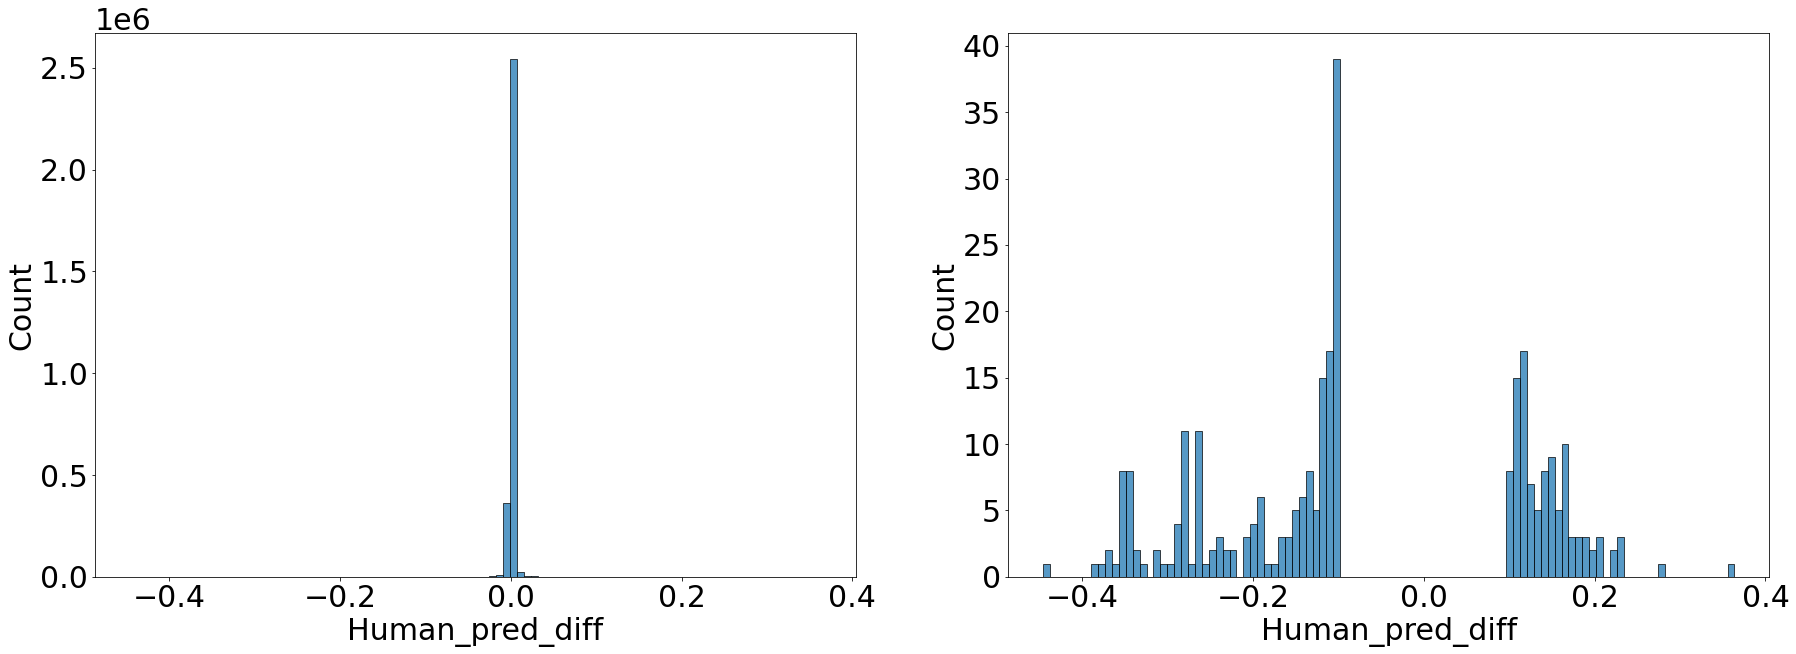

In [24]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

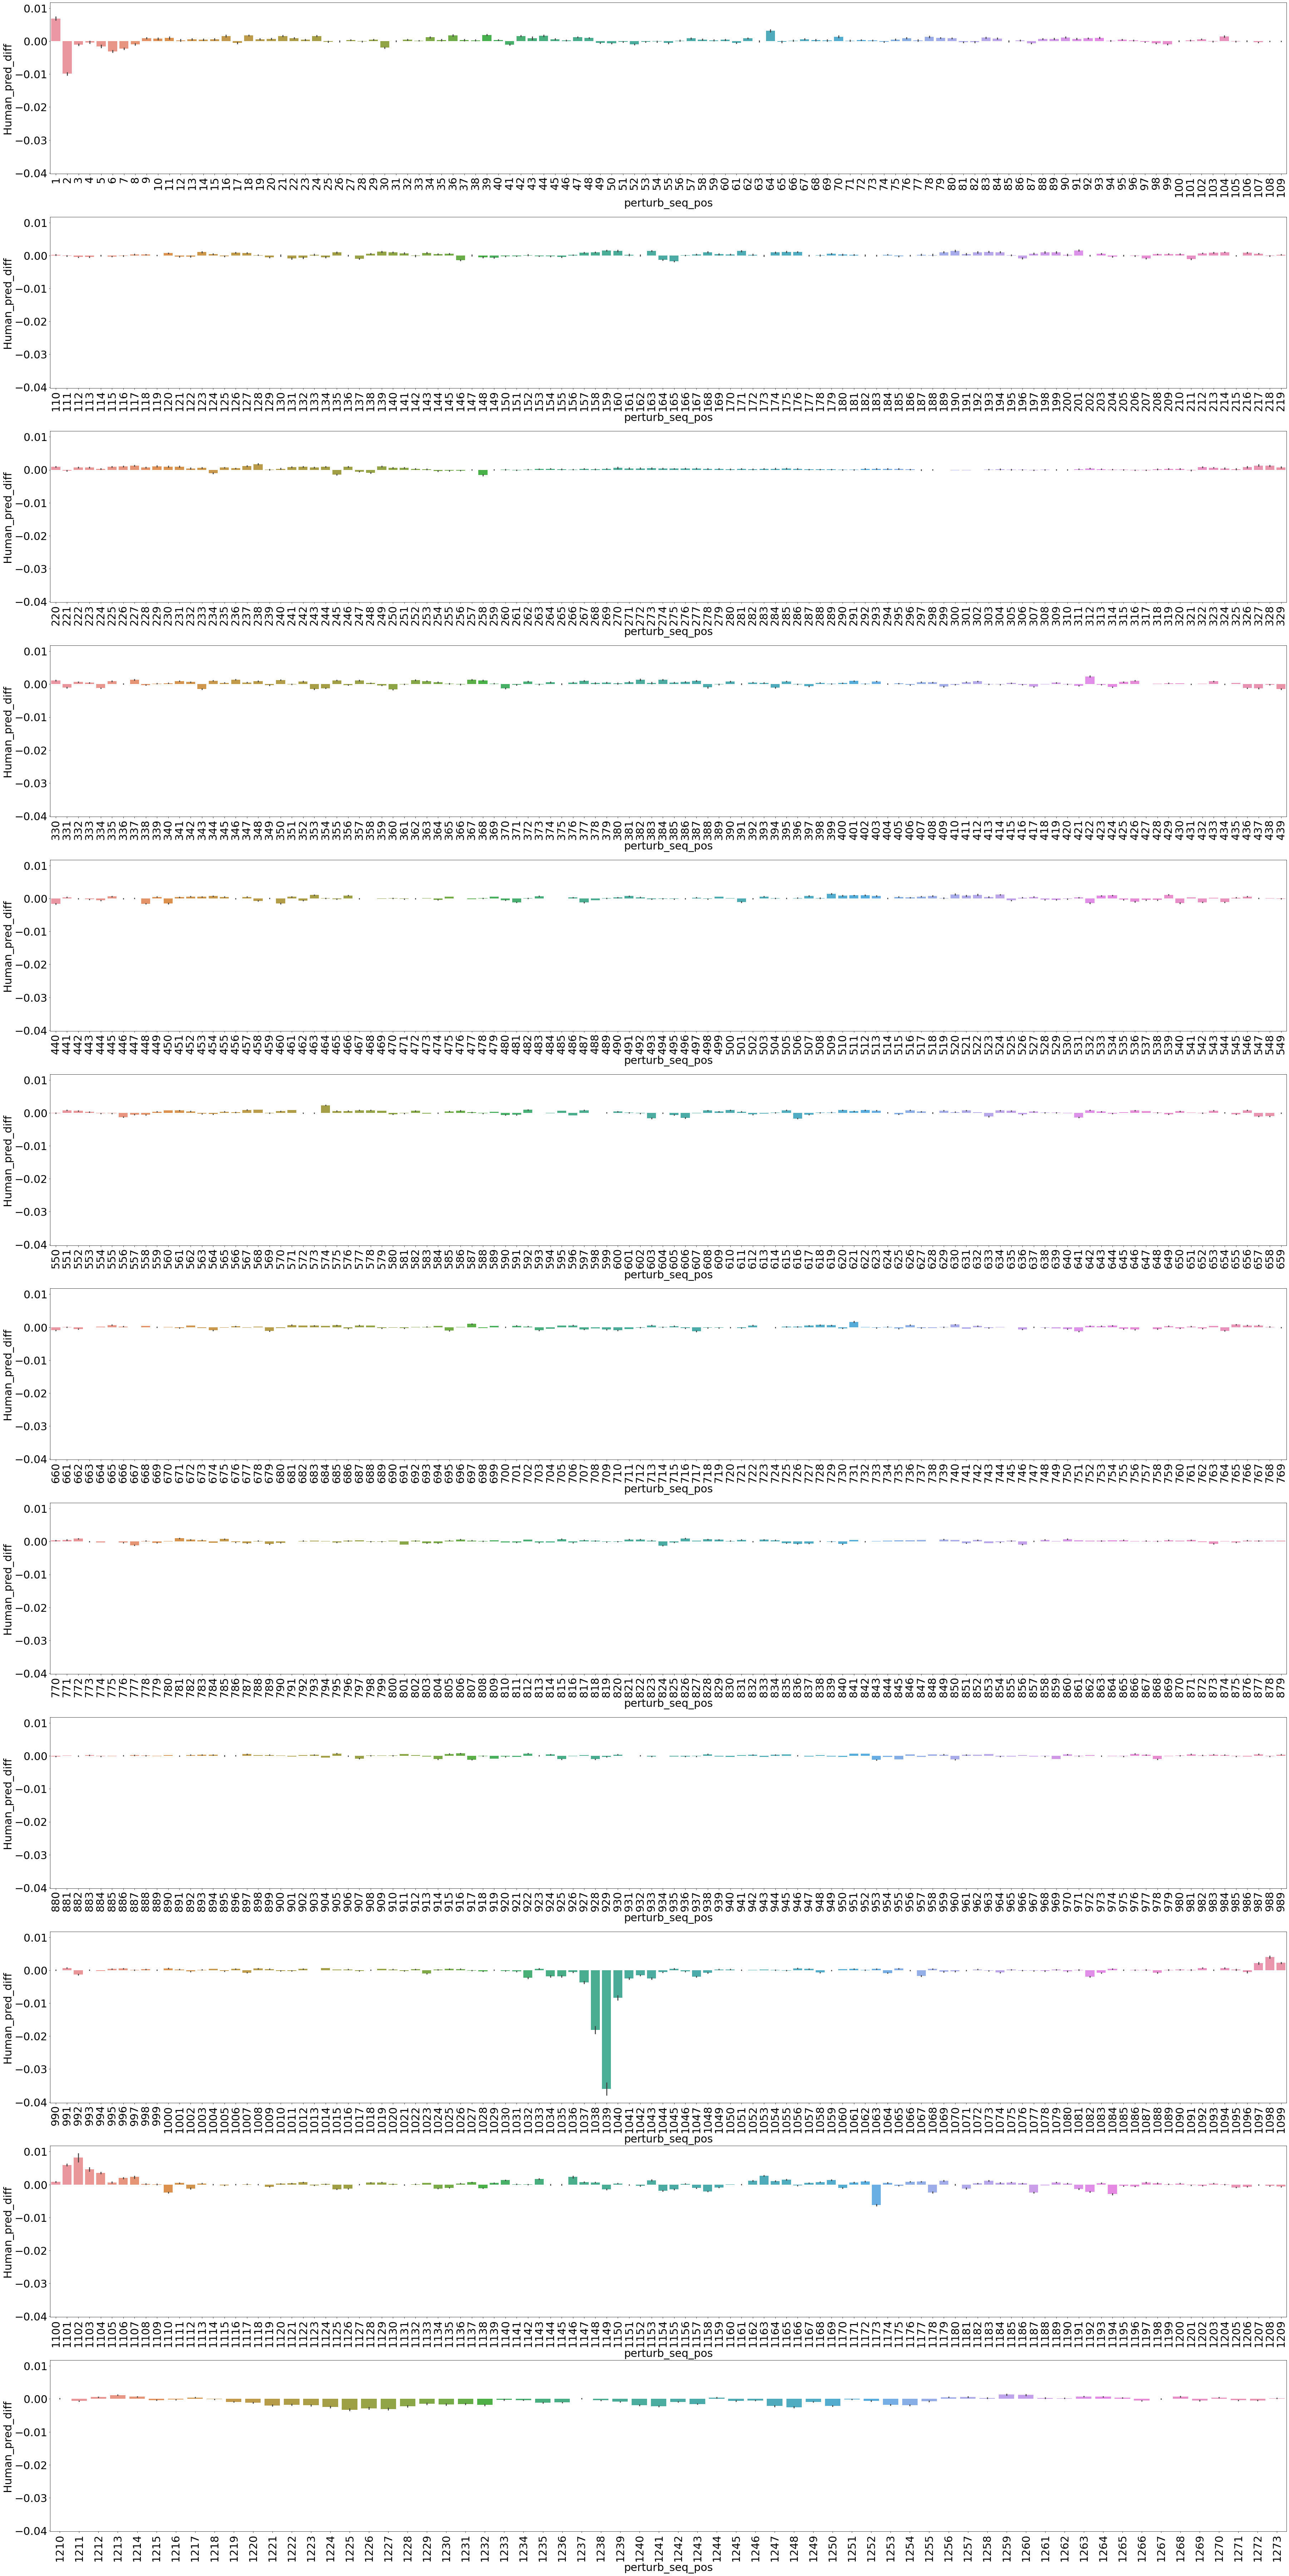

In [25]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(12, 1, figsize=(50, 100), sharex=False, sharey=True)

j = 0
for i in range(0, 1274, 110):
    plot_df = perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] >= i) & (perturbed_output_df["perturb_seq_pos"] < i+110)]
    sns.barplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

# plt.clf()
# plt.figure(figsize=(70, 20))
# plt.rcParams["xtick.labelsize"] = 10
# plt.rcParams["ytick.labelsize"] = 10
# plt.rcParams.update({'font.size': 10})
# sns.barplot(perturbed_output_df, x="perturb_seq_pos", y=pred_diff_col)
# plt.xticks(rotation=90)
# plt.show()

In [26]:
perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] > 500) & (perturbed_output_df["abs_Human_pred_diff"] > 0)]

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
0,3.646653e-08,0.000455,0.282759,0.000003,0.000108,0.318339,0.396981,0.001354,WIV04,Human,K,1037,J,-0.190584,0.190584,Human,Human,1038
1,2.361889e-08,0.000448,0.208778,0.000002,0.000094,0.221644,0.568144,0.000890,WIV04,Human,P,1111,W,-0.019422,0.019422,Human,Human,1112
2,2.533365e-08,0.000429,0.207266,0.000002,0.000088,0.210399,0.580933,0.000882,WIV04,Human,S,874,V,-0.006632,0.006632,Human,Human,875
4,2.991777e-08,0.000481,0.211196,0.000002,0.000102,0.217975,0.569302,0.000942,WIV04,Human,K,1148,M,-0.018263,0.018263,Human,Human,1149
5,2.378495e-08,0.000416,0.204850,0.000002,0.000084,0.206861,0.586923,0.000864,WIV04,Human,K,1254,S,-0.000643,0.000643,Human,Human,1255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31595,1.594863e-07,0.000151,0.032445,0.000005,0.000040,0.008251,0.958516,0.000592,UniRef90_A0A8B1JFM7,Human,D,561,K,0.001466,0.001466,Human,Human,571
31597,1.422294e-07,0.000158,0.032334,0.000005,0.000039,0.008488,0.958406,0.000569,UniRef90_A0A8B1JFM7,Human,T,1150,Y,0.001356,0.001356,Human,Human,1160
31598,1.631860e-07,0.000147,0.034530,0.000006,0.000039,0.008727,0.955913,0.000638,UniRef90_A0A8B1JFM7,Human,G,1257,P,-0.001138,0.001138,Human,Human,1267
31599,1.622588e-07,0.000148,0.033353,0.000006,0.000039,0.008349,0.957492,0.000613,UniRef90_A0A8B1JFM7,Human,V,1258,D,0.000442,0.000442,Human,Human,1268


### Cut-off: mean=0 and variance=0

In [51]:
mean_std_df = perturbed_output_df.groupby("perturb_seq_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_seq_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isin(cut_off_pos)]
cut_off_df_1["perturb_seq_pos"].nunique()

1273

<Figure size 432x288 with 0 Axes>

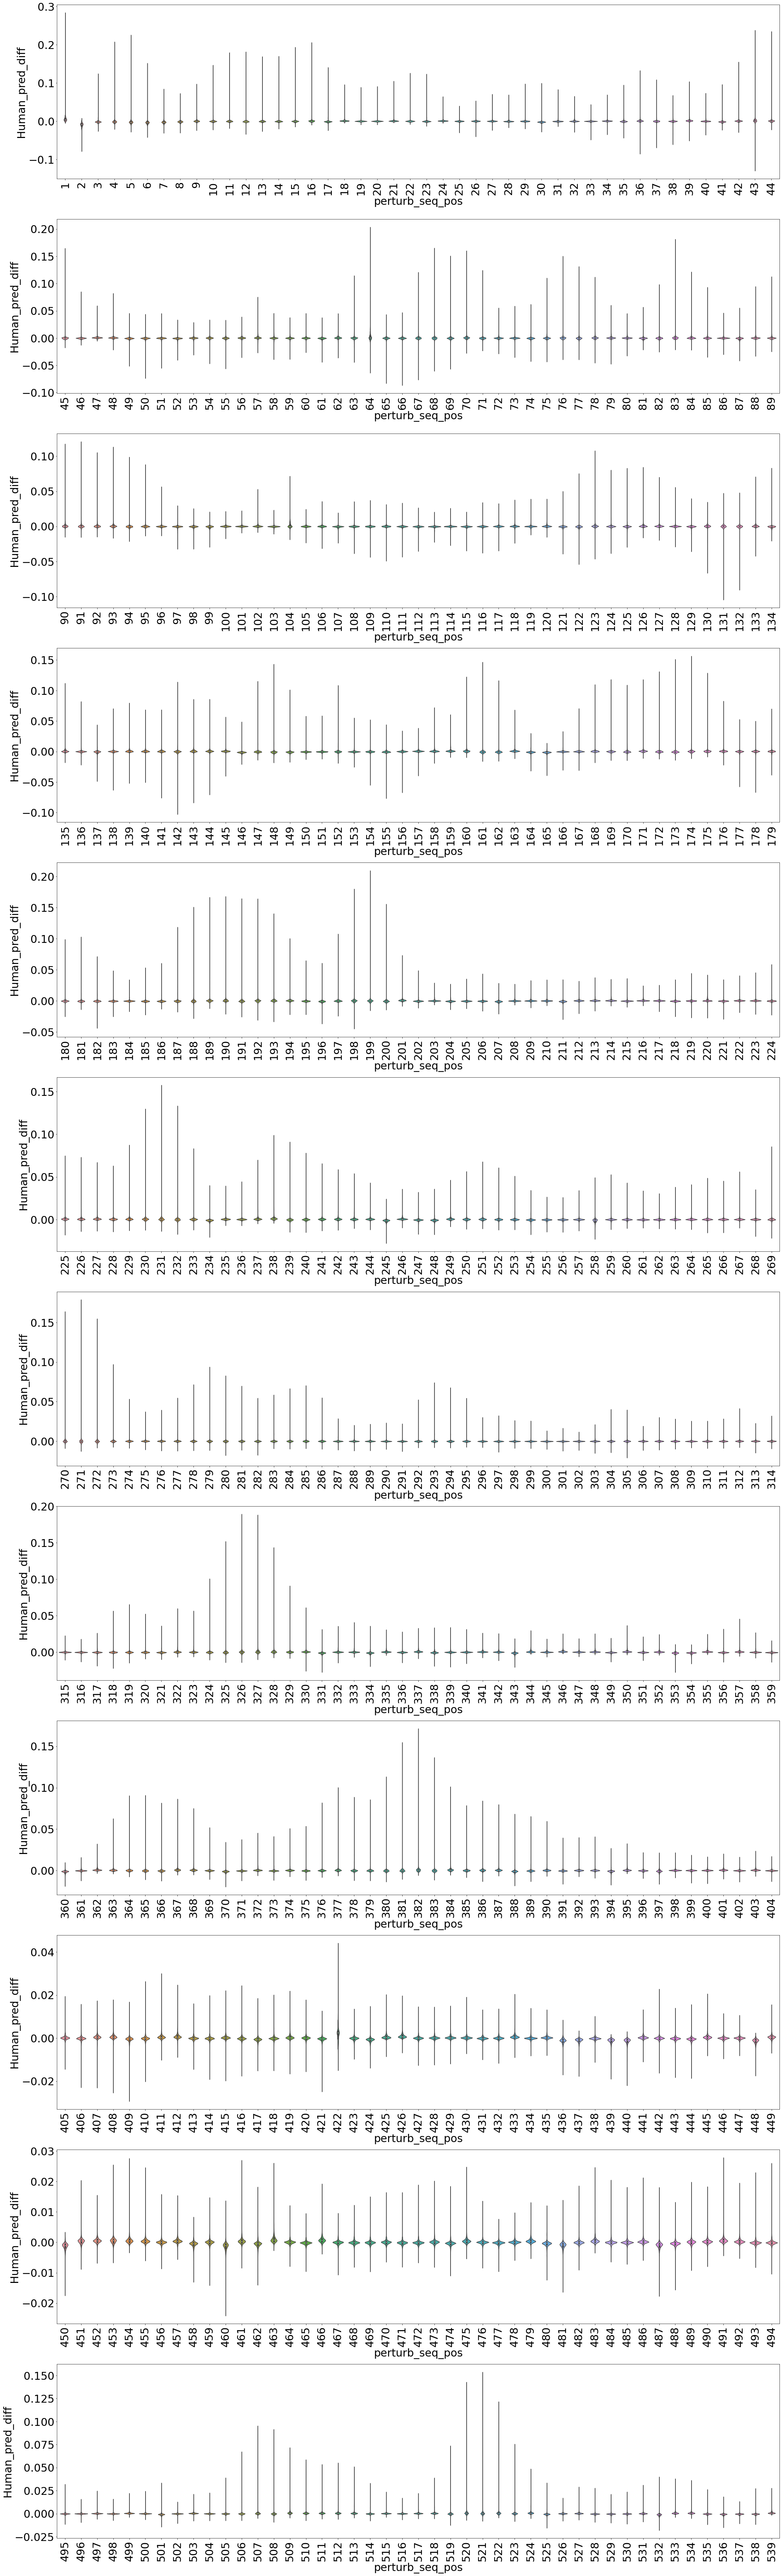

In [52]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(12, 1, figsize=(30, 100), sharex=False, sharey=False)

j = 0
for i in range(0, 501, 45):
    plot_df = cut_off_df_1[(cut_off_df_1["perturb_seq_pos"] >= i) & (cut_off_df_1["perturb_seq_pos"] < i+45)]
    sns.violinplot(plot_df, x="perturb_seq_pos", y=pred_diff_col, ax=axs[j])
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.05

In [54]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.05]
cut_off_pos_1 = set(cut_off_df_1["perturb_seq_pos"].unique())
cut_off_pos_2 = set(cut_off_df_2["perturb_seq_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 1273
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 325
1 intersection 2: 325
1 minus 2: 948
2 minus 1: 0
is 2 subset of 1: True


<Figure size 432x288 with 0 Axes>

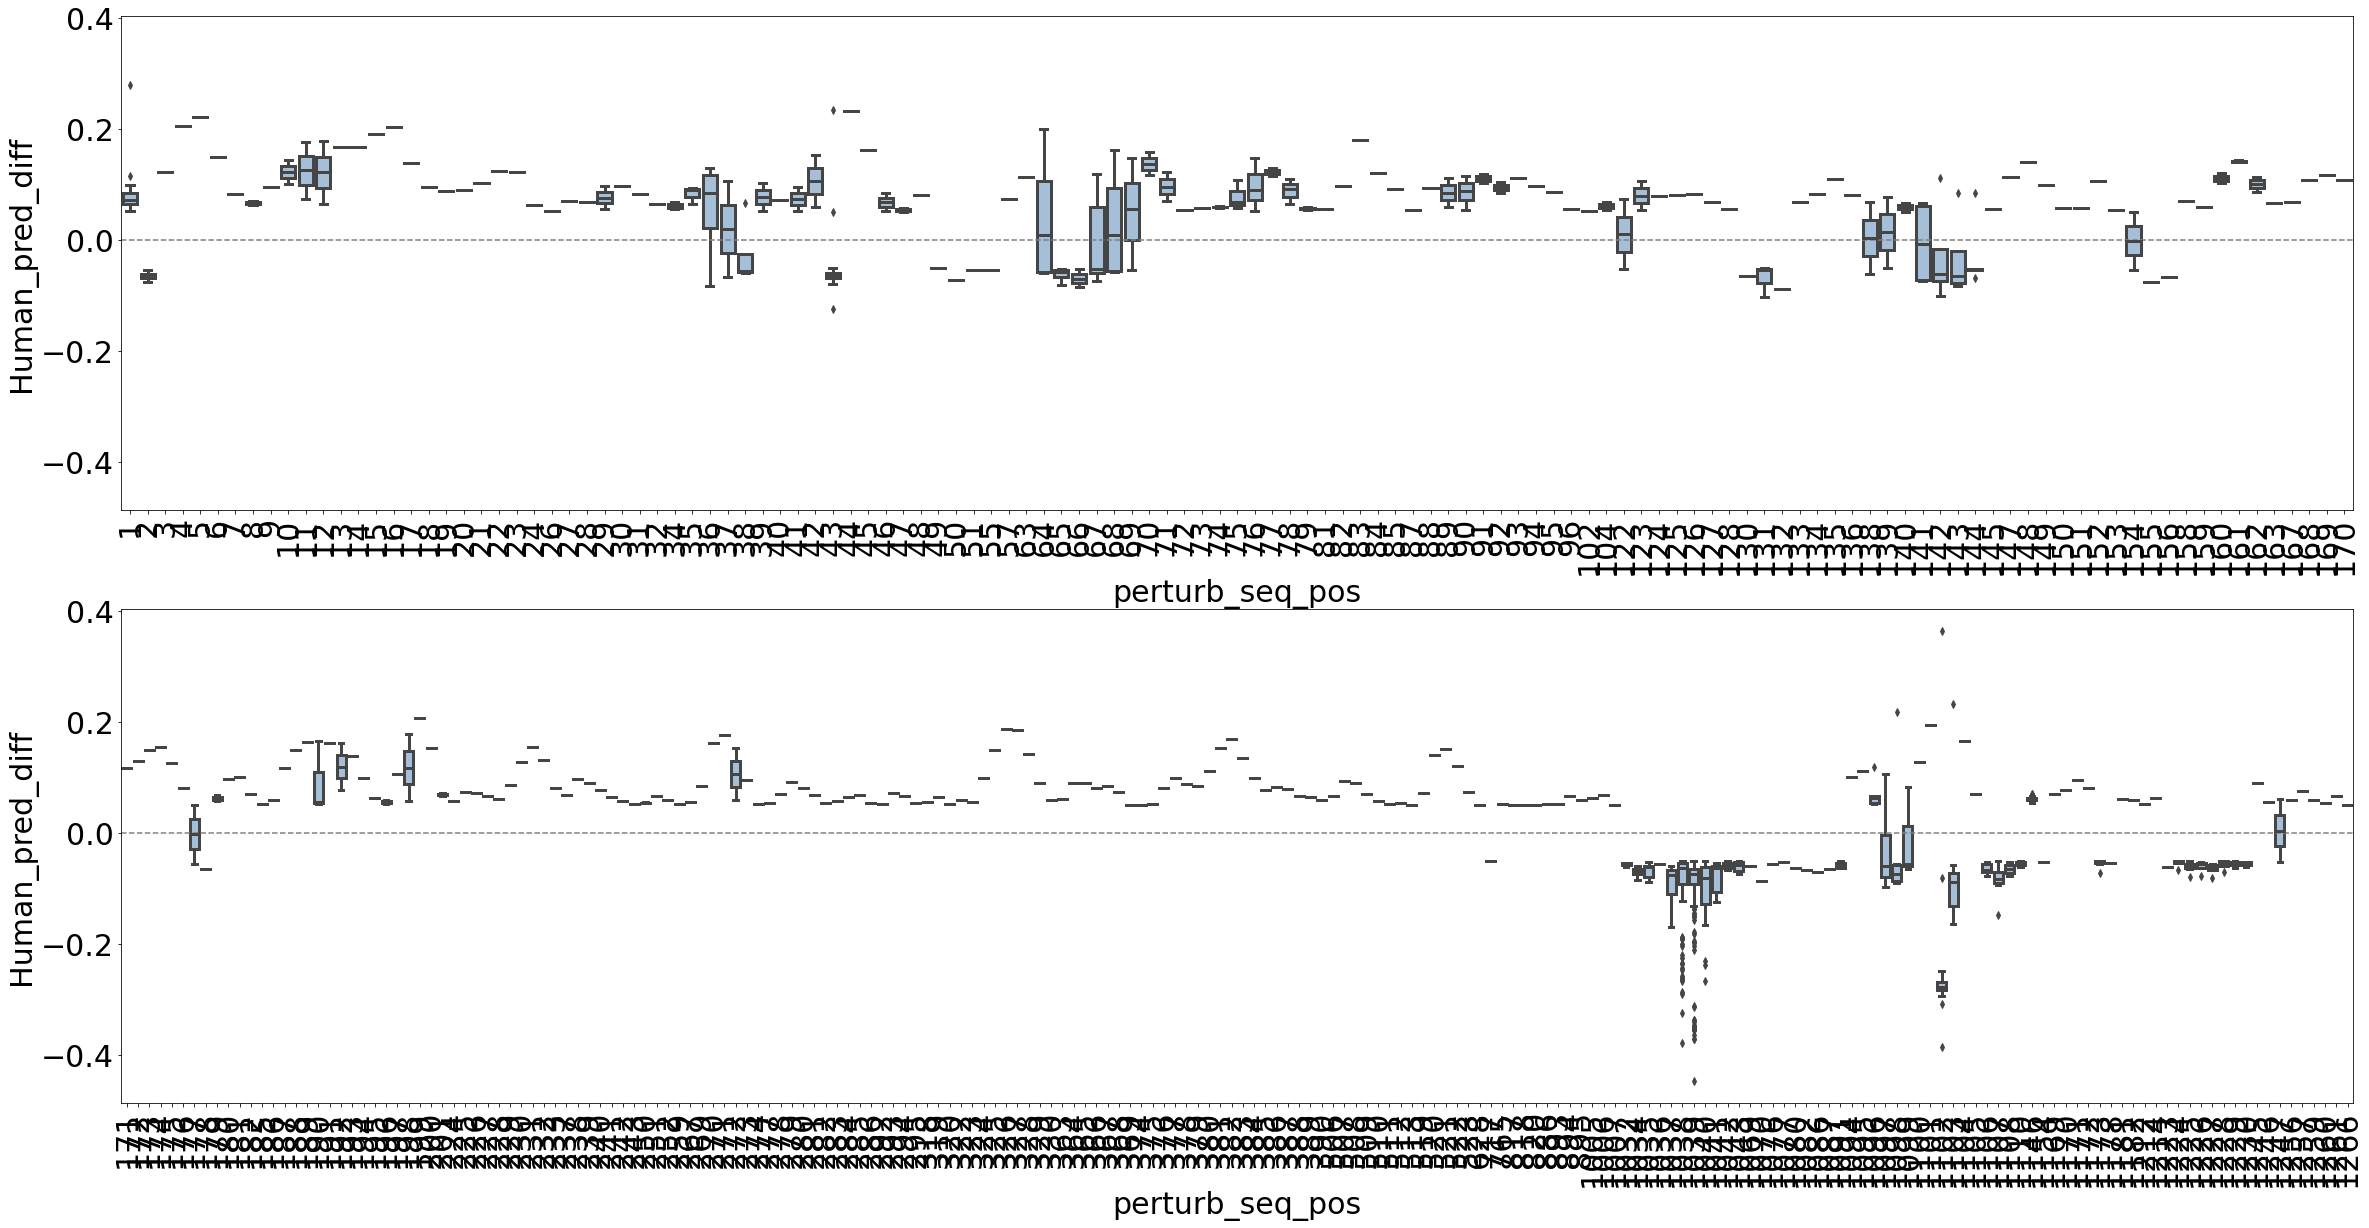

In [55]:
plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(40, 20), sharey=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"] <= 170],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[0], orient="v", 
            linewidth=3,
            boxprops={"facecolor": (.3, .5, .7, .5)})
axs[0].tick_params(axis='x', rotation=90)
axs[0].axhline(0.0, color="gray", linestyle="--")
sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"] > 170],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[1], orient="v", 
            linewidth=3,
            boxprops={"facecolor": (.3, .5, .7, .5)})
axs[1].tick_params(axis='x', rotation=90)
axs[1].axhline(0.0, color="gray", linestyle="--")
#sns.stripplot(data=cut_off_df_2, x="Human_pred_diff", y="perturb_seq_pos", hue="new_token", orient="h", s=10, ax=axs[1], linewidth=1)

plt.show()


### Important positions causing class change from Human

59
40.67796610169492


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 432x288 with 0 Axes>

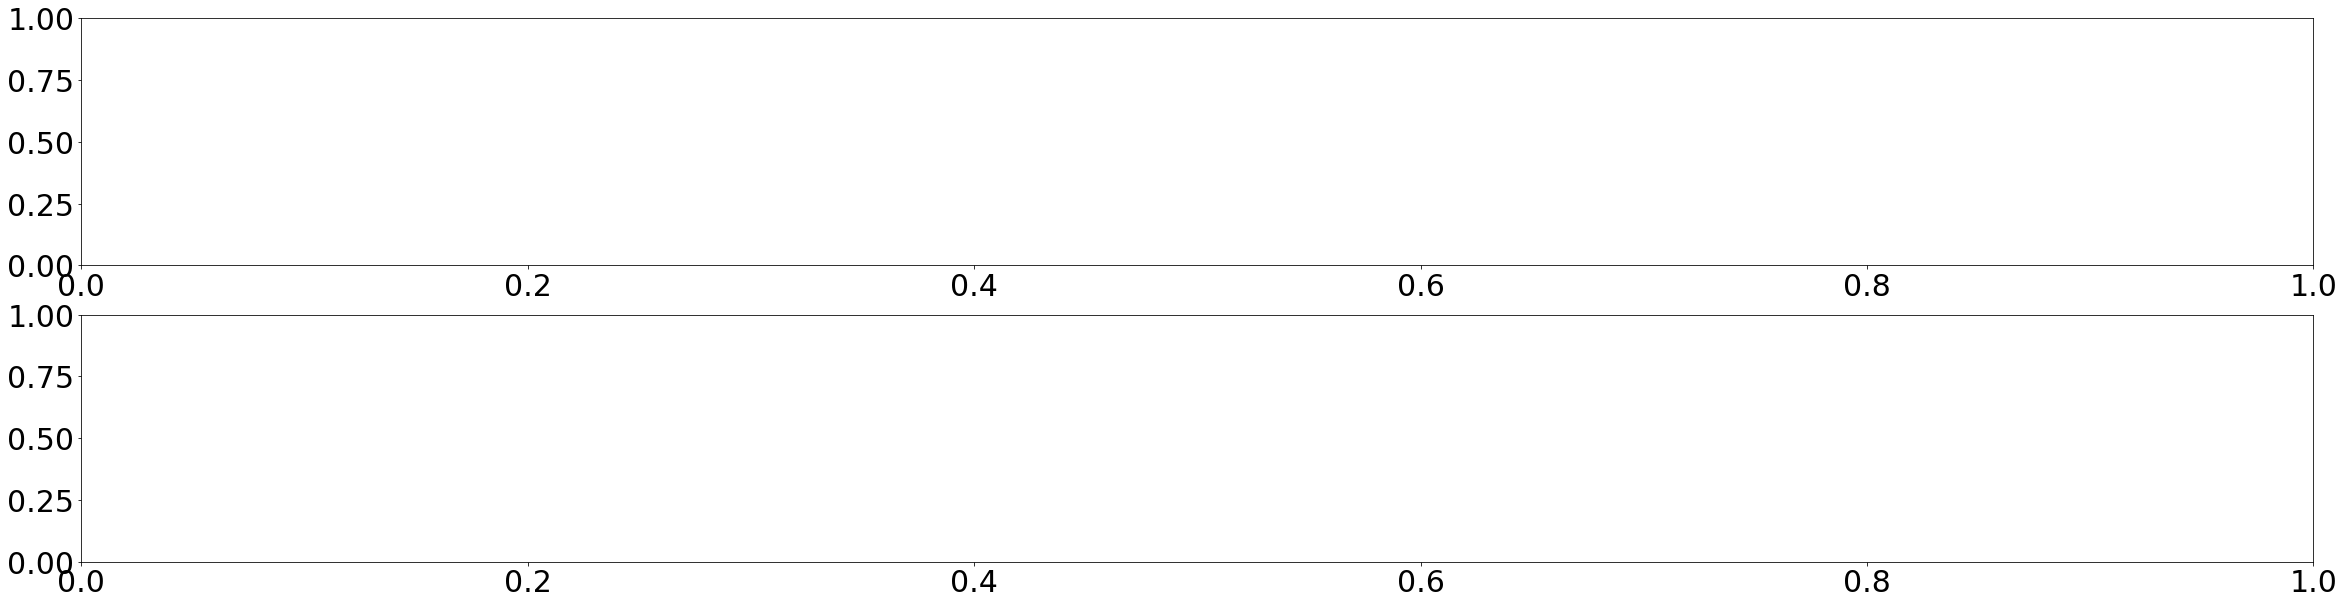

In [56]:
class_change_df = perturbed_output_df[(perturbed_output_df["orig_y_pred"] == "Human") & (perturbed_output_df["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
max_val = df["%"].max()
print(max_val)
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
df = df.reset_index()
# df.drop(["new_y_pred"], axis=1, inplace=True)

plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(40, 10), sharey=True)
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

sns.heatmap(data=df[df["perturb_seq_pos"] <=250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[0], vmax=max_val)
wrap_yticklabels(axs[0], label_width=10, break_long_words=True)
axs[0].tick_params(axis='x', rotation=90)


sns.heatmap(data=df[df["perturb_seq_pos"] > 250].set_index("perturb_seq_pos").T, linewidth=.1, cmap="crest", ax=axs[1], vmax=max_val)
wrap_yticklabels(axs[1], label_width=10, break_long_words=True)
axs[1].tick_params(axis='x', rotation=90)
plt.tight_layout(pad=.1)
plt.show()


### Important positions causing class change from Human due to difference >= 0.1

59


<Figure size 432x288 with 0 Axes>

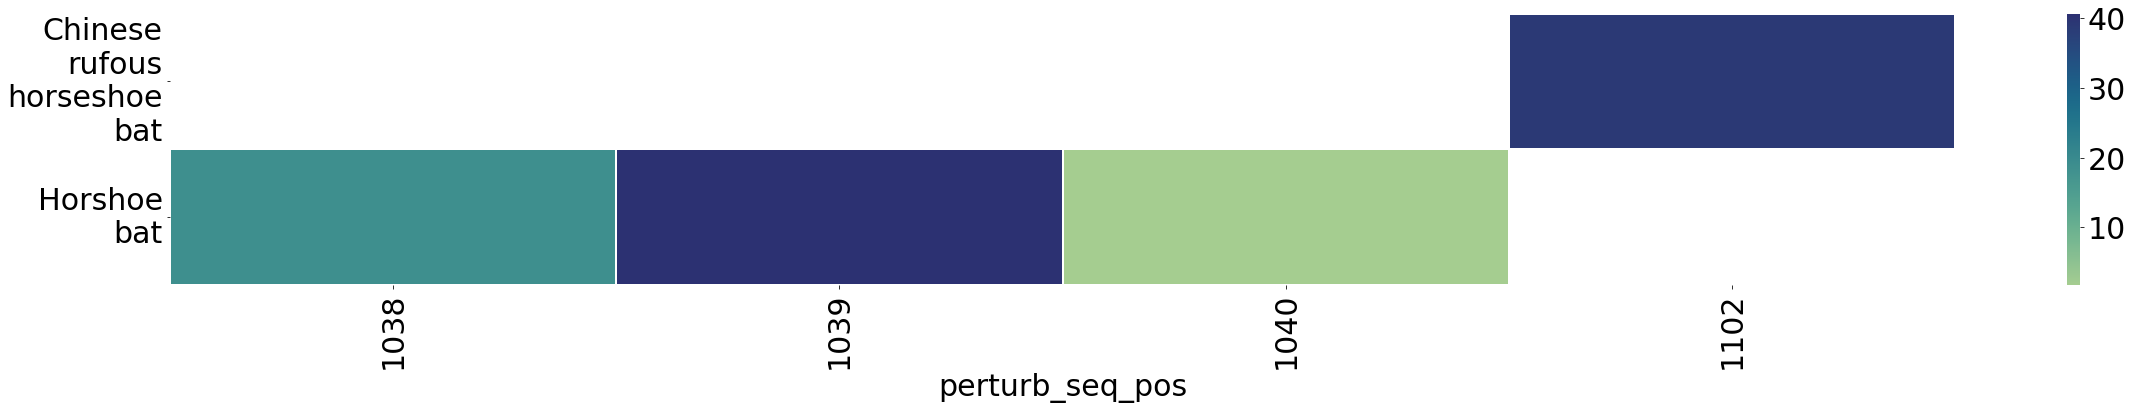

In [57]:
class_change_df = cut_off_df_2[(cut_off_df_2["orig_y_pred"] == "Human") & (cut_off_df_2["new_y_pred"] != "Human")]
n = class_change_df.shape[0]
print(n)
df = class_change_df[["uniref90_id", "perturb_seq_pos", "new_y_pred"]].groupby(["perturb_seq_pos", "new_y_pred"]).count().reset_index()
df["%"] = df["uniref90_id"]/n*100
df = df.pivot(index="perturb_seq_pos", columns="new_y_pred", values="%")
df.columns.name = None
# df.drop(["new_y_pred"], axis=1, inplace=True)
plt.clf()
plt.figure(figsize=(40, 5))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.heatmap(data=df.T, linewidth=.1, cmap="crest")
wrap_yticklabels(ax, label_width=10, break_long_words=True)
ax.tick_params(axis='x', rotation=90)
plt.show()

## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [58]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]
non_x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] != "X"].copy()

/tmp/ipykernel_3859195/3113693862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]


In [59]:
#!pip install textalloc


<Figure size 432x288 with 0 Axes>

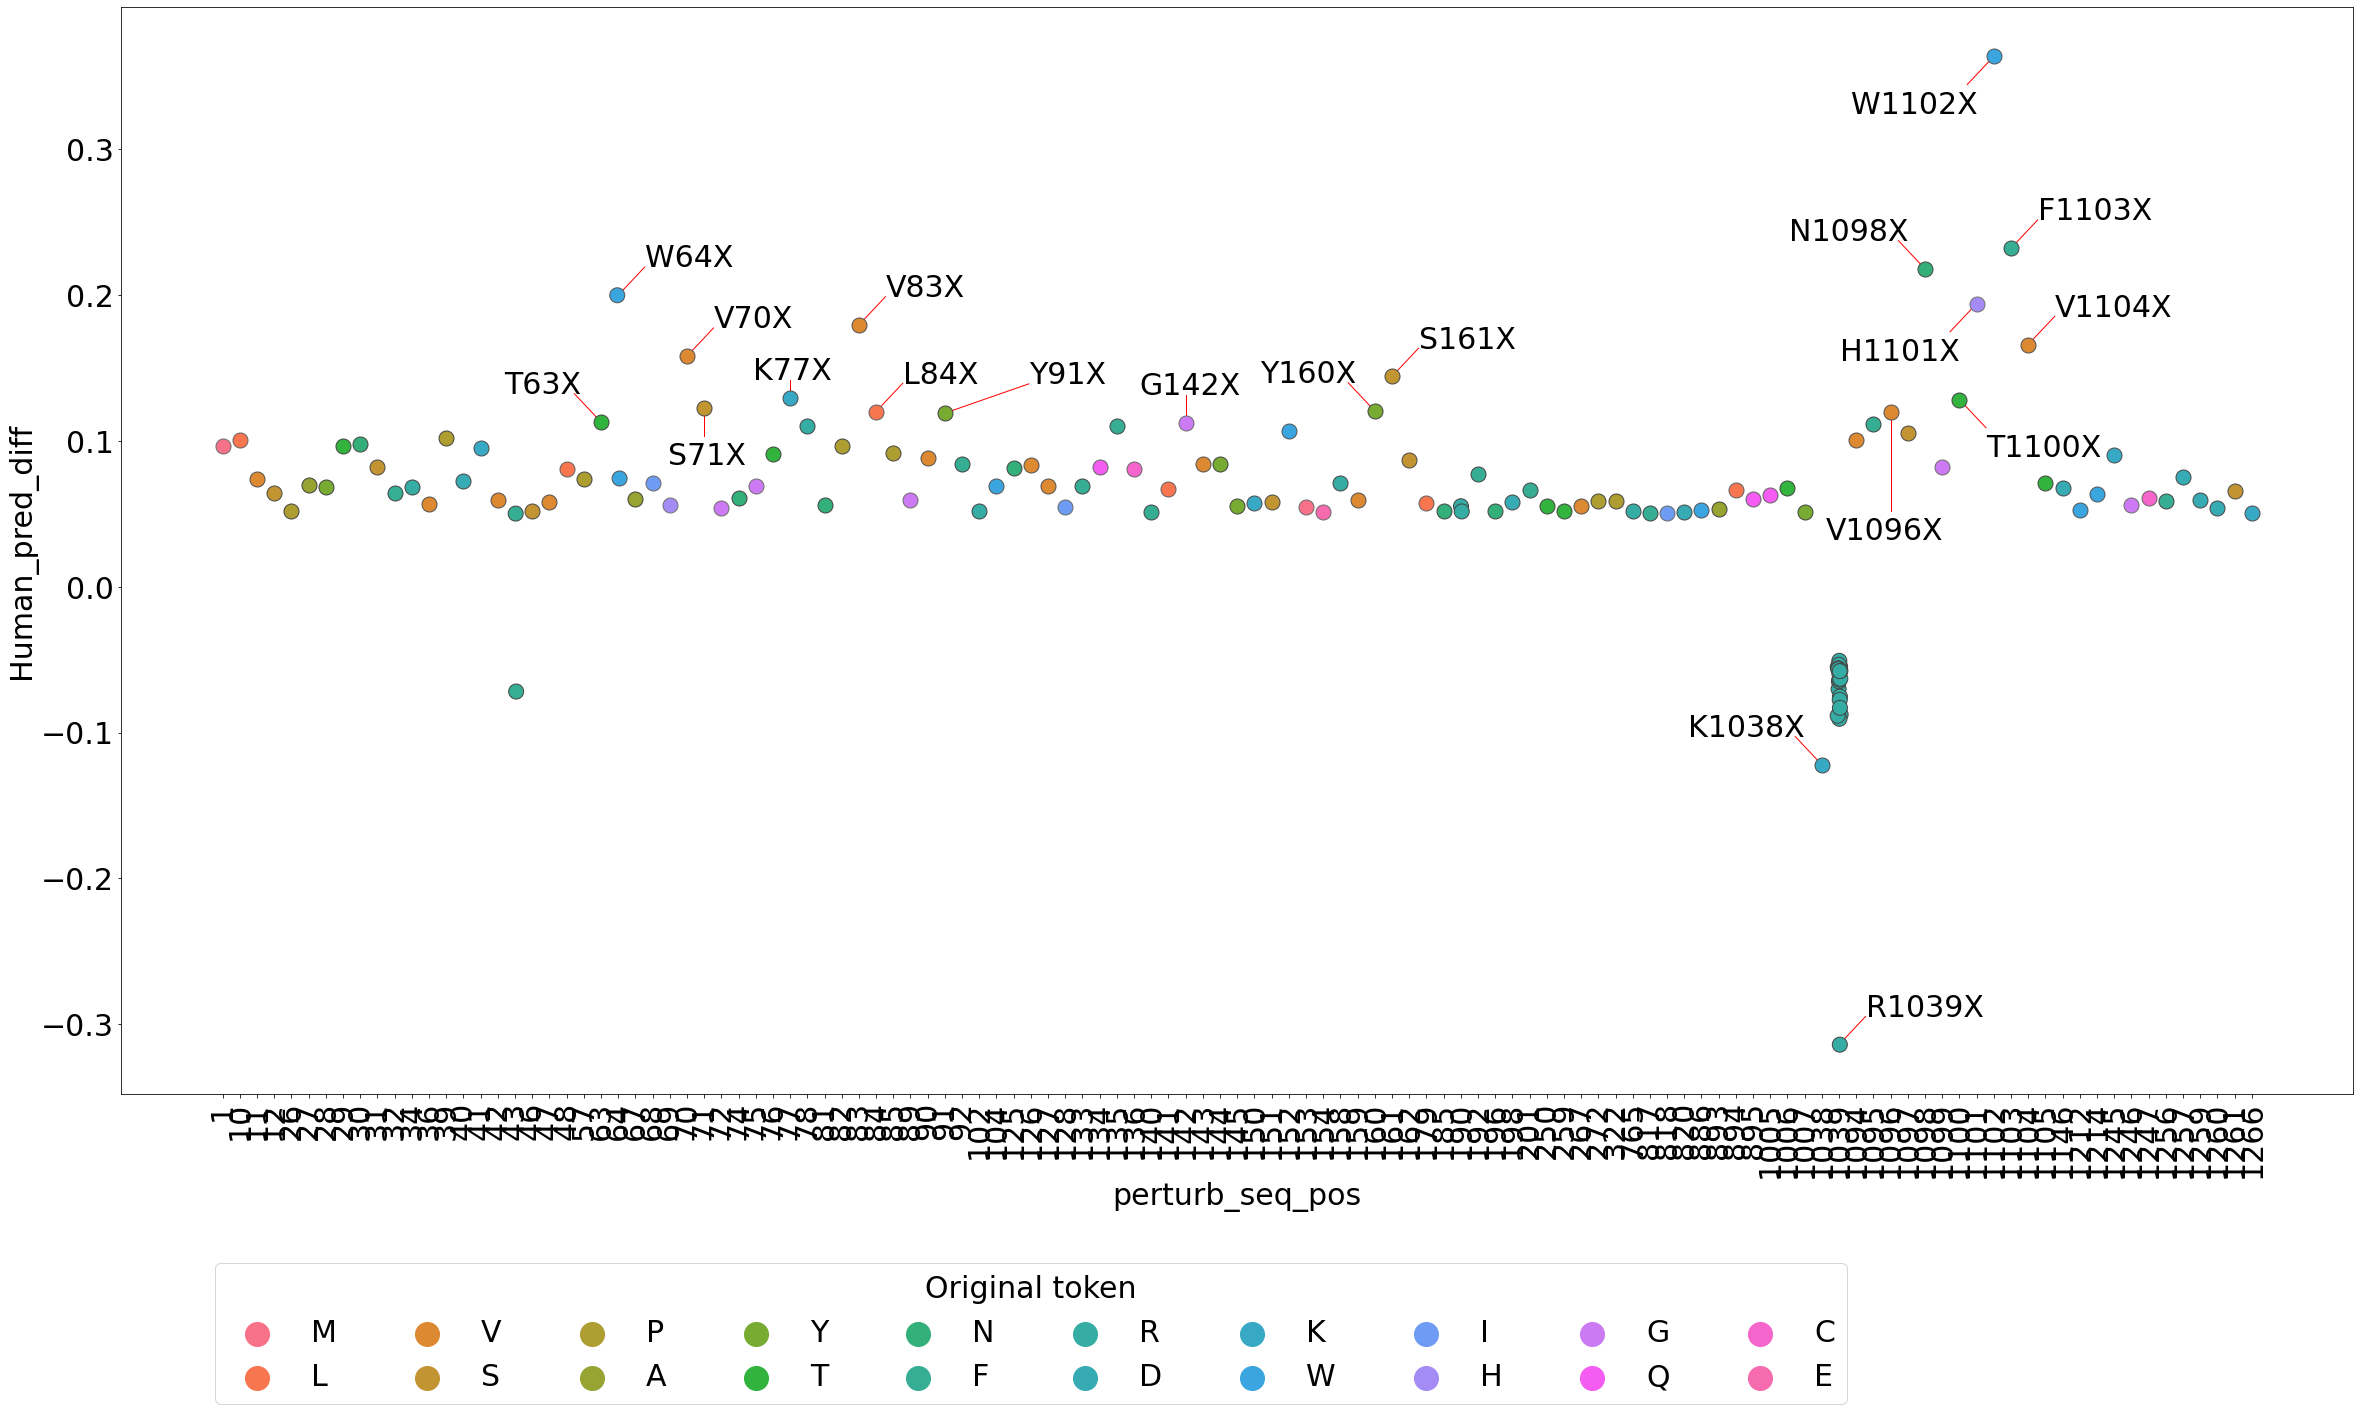

In [60]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_seq_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [61]:
annotate_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos,perturbation_id
24324,4.953862e-09,0.000117,0.031778,2.834400e-07,0.000017,0.016701,0.951247,0.000139,WIV04,Human,W,1101,X,0.363681,0.363681,Human,Human,1102,W1102X
4047,5.458458e-08,0.000495,0.332252,4.449098e-06,0.000131,0.391638,0.273621,0.001860,WIV04,Human,R,1038,X,-0.313945,0.313945,Human,Horshoe bat,1039,R1039X
17716,1.207979e-08,0.000259,0.100205,7.926665e-07,0.000046,0.079433,0.819652,0.000405,WIV04,Human,F,1102,X,0.232087,0.232087,Human,Human,1103,F1103X
16153,1.221478e-08,0.000266,0.107303,7.932330e-07,0.000045,0.086504,0.805481,0.000400,WIV04,Human,N,1097,X,0.217915,0.217915,Human,Human,1098,N1098X
8946,1.533521e-08,0.000334,0.116040,9.125105e-07,0.000055,0.095729,0.787406,0.000434,WIV04,Human,W,63,X,0.199840,0.199840,Human,Human,64,W64X
23183,1.455348e-08,0.000314,0.118912,8.851671e-07,0.000050,0.098584,0.781719,0.000421,WIV04,Human,H,1100,X,0.194153,0.194153,Human,Human,1101,H1101X
21718,1.547716e-08,0.000332,0.125194,9.958953e-07,0.000058,0.106860,0.767054,0.000501,WIV04,Human,V,82,X,0.179488,0.179488,Human,Human,83,V83X
29203,1.762445e-08,0.000376,0.131161,1.082916e-06,0.000063,0.114228,0.753649,0.000522,WIV04,Human,V,1103,X,0.166083,0.166083,Human,Human,1104,V1104X
26688,1.606049e-08,0.000343,0.135223,1.052613e-06,0.000060,0.118218,0.745616,0.000538,WIV04,Human,V,69,X,0.158050,0.158050,Human,Human,70,V70X
3599,1.806786e-08,0.000366,0.140863,1.163423e-06,0.000065,0.126386,0.731744,0.000574,WIV04,Human,S,160,X,0.144179,0.144179,Human,Human,161,S161X


### Mutations with new token NOT = X

In [62]:
print(f"New token != X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

New token != X = (1217, 19)
Number of unique mutations = 585


<Figure size 432x288 with 0 Axes>

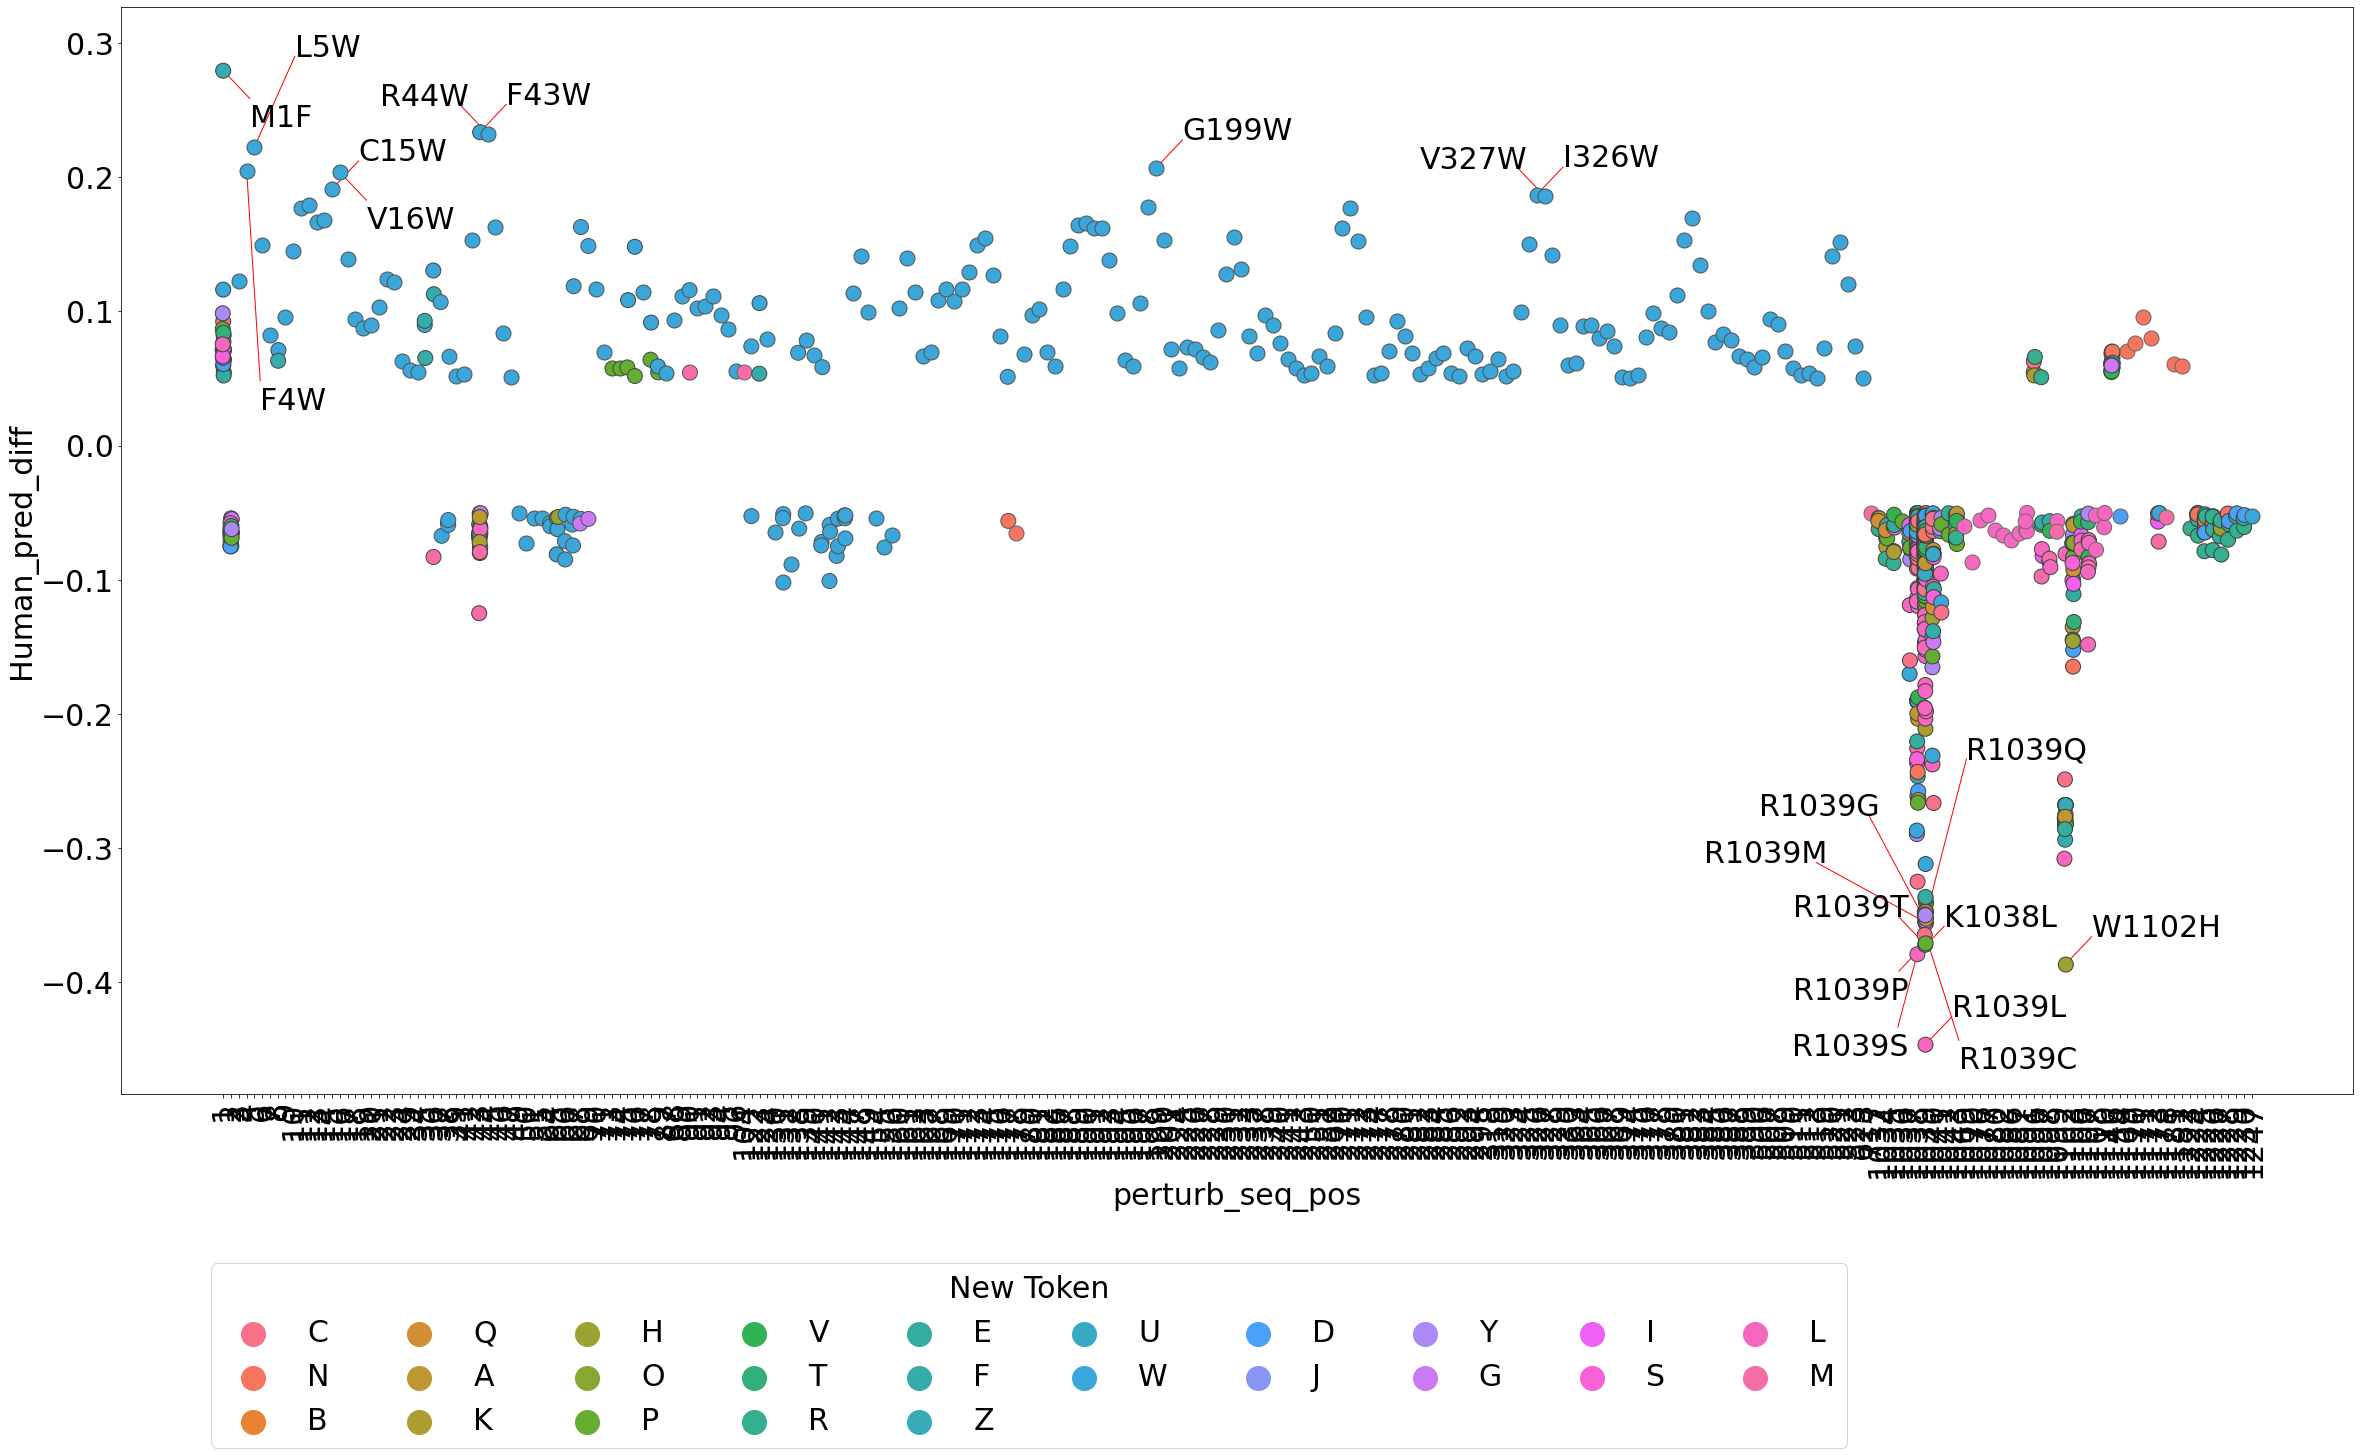

In [63]:
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [64]:
cut_off_df_2["perturbation_id"].nunique()

704

<Figure size 432x288 with 0 Axes>

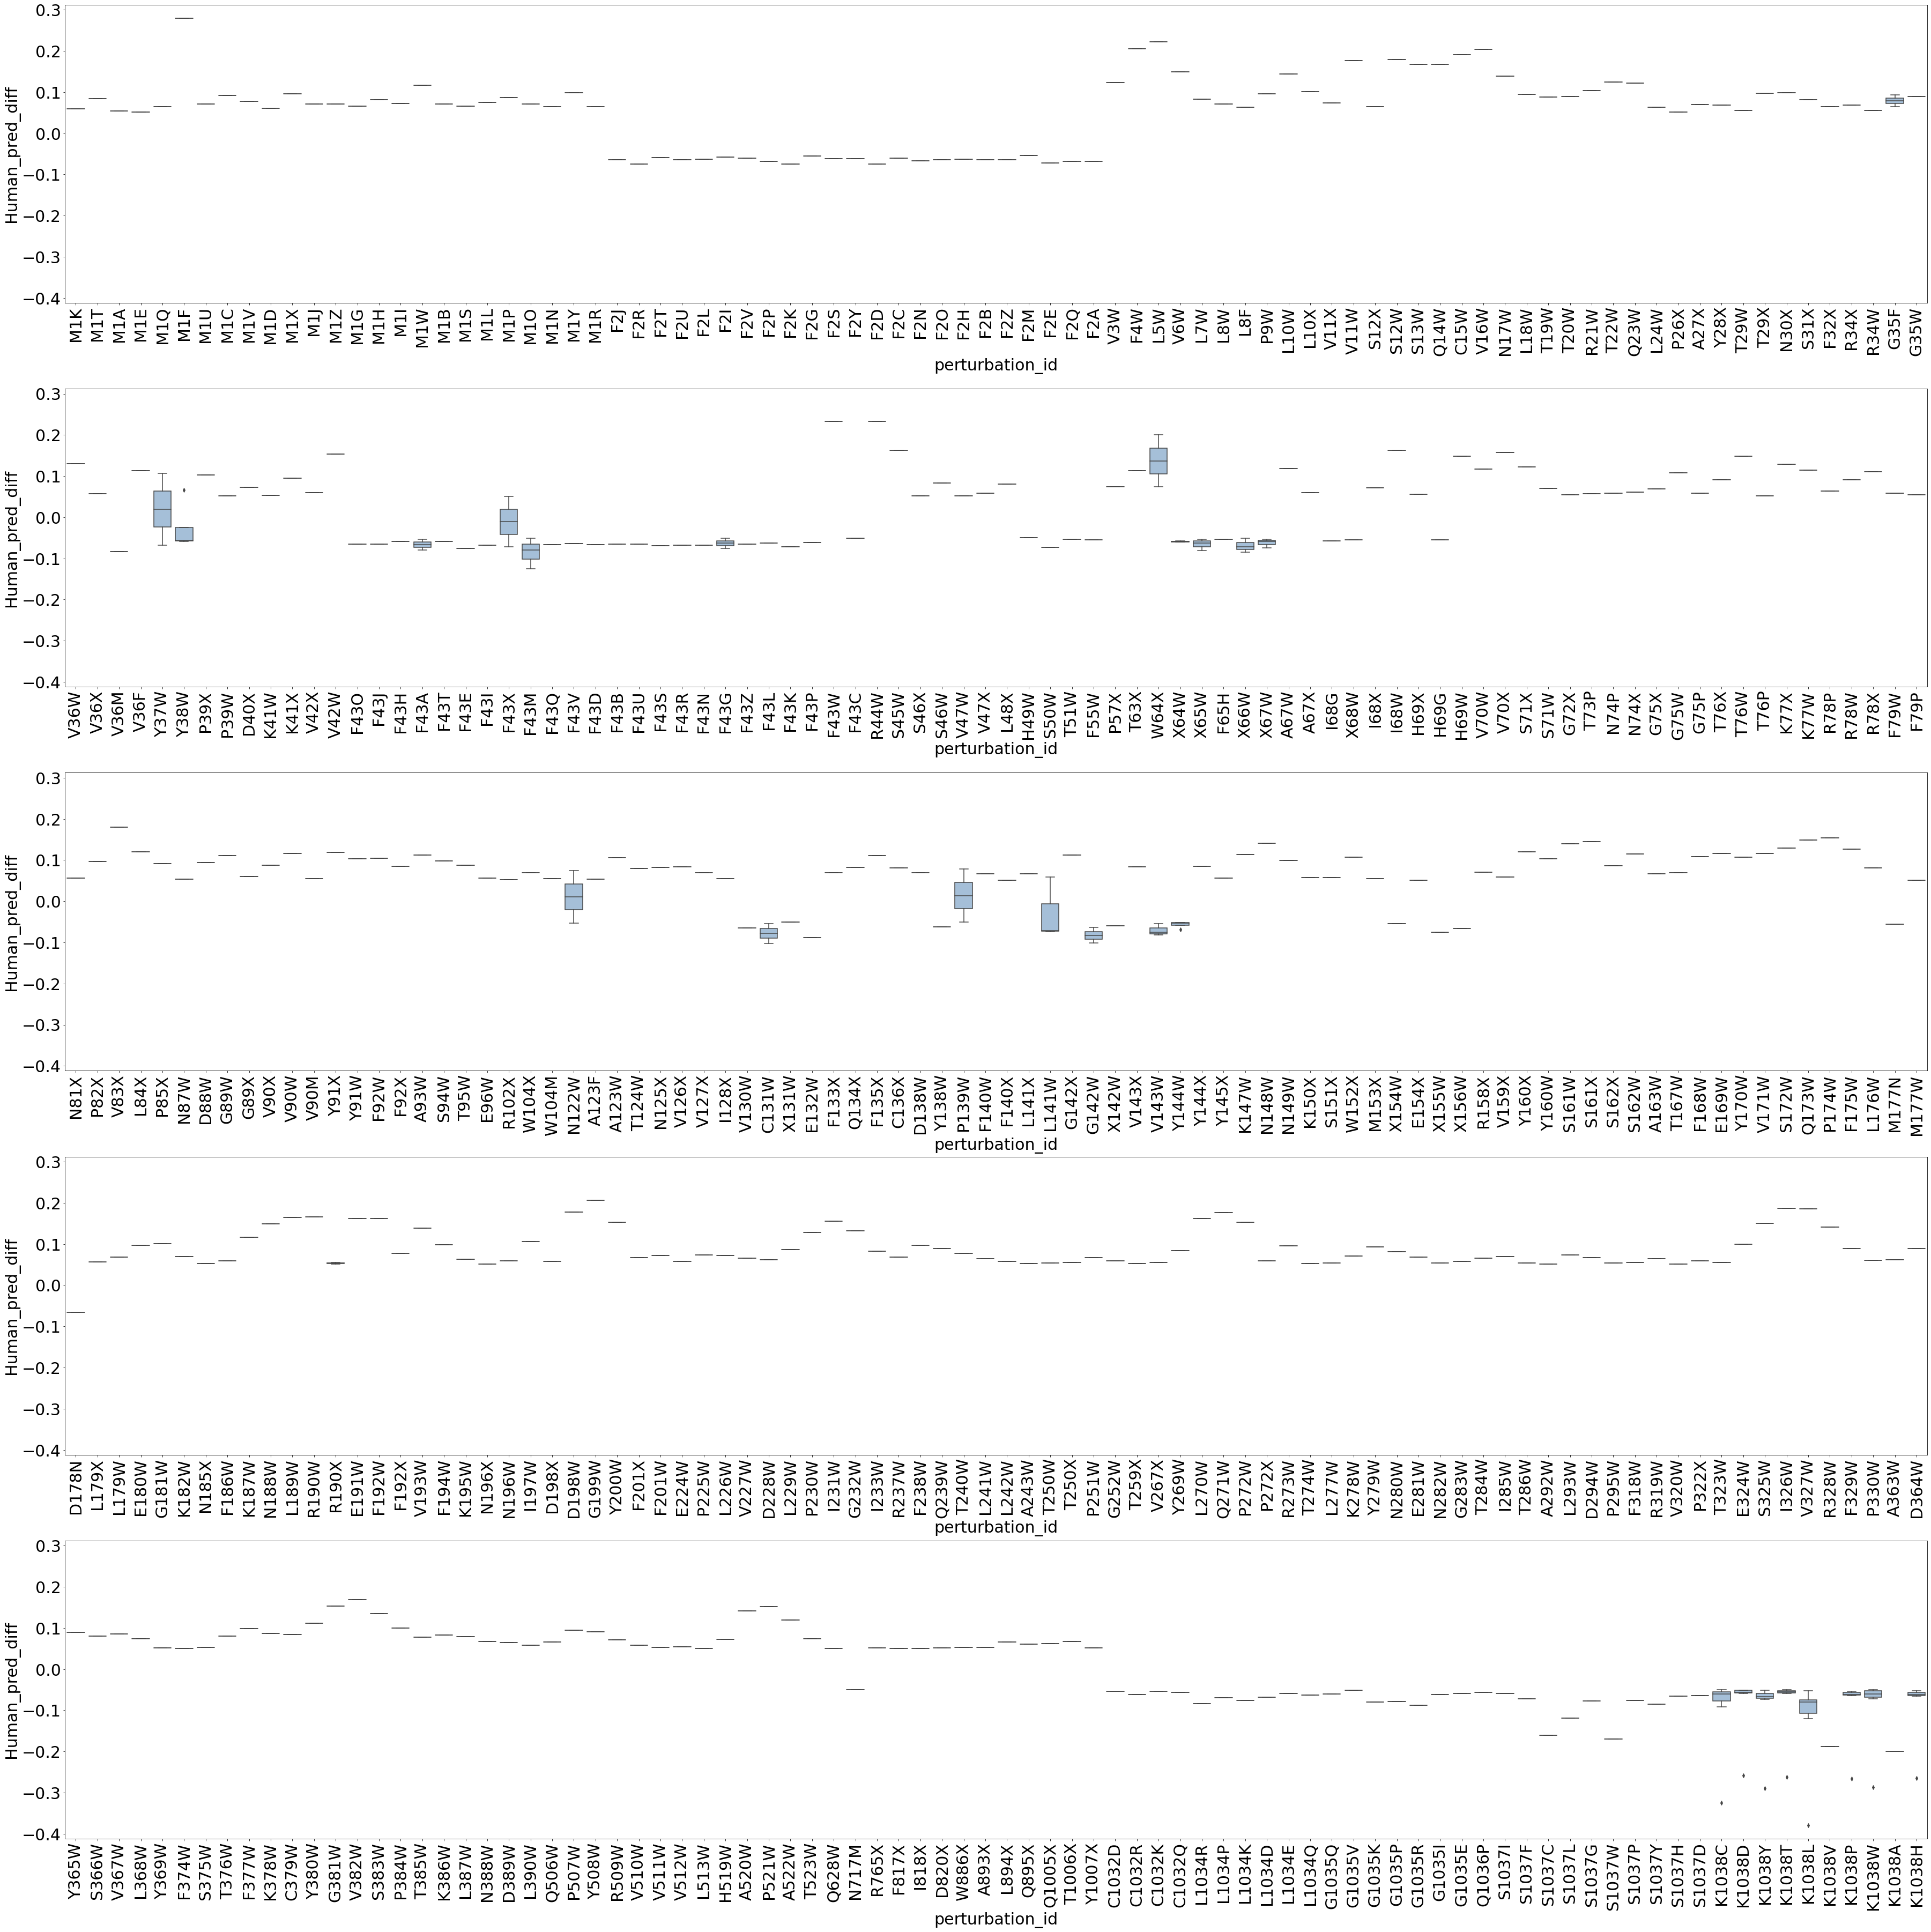

In [65]:
plt.clf()
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

perturbation_ids = cut_off_df_2.sort_values("perturb_seq_pos")["perturbation_id"].unique()
fig, axs = plt.subplots(5, 1, figsize=(50, 50), sharex=False, sharey=True)

j = 0
for i in range(0, 426, 86):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(perturbation_ids[i:i+86])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs[j], orient="v", order=perturbation_ids[i:i+86],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[j].tick_params(axis='x', rotation=90)
    j += 1
    
plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [66]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","input/data/coronaviridae/20240313/wiv04/s_mutations.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

,orig_token,pos,new_token,perturbation_id
0,D,614,G,D614G
1,S,943,P,S943P
2,E,484,K,E484K
3,N,501,Y,N501Y
4,L,452,R,L452R
5,Q,677,P,Q677P
6,Q,677,H,Q677H
7,P,681,H,P681H
8,E,484,Q,E484Q
9,K,417,N,K417N


In [67]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)

/tmp/ipykernel_3859195/742767506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)


In [68]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["perturbation_id"])]
known_mutations_stats = known_mutations_df[["uniref90_id", "perturbation_id"]].groupby("perturbation_id").count().reset_index()
known_mutations_stats.rename(columns={"uniref90_id": "n_unique_sequences"}, inplace=True)
known_mutations_stats["percentage"] = known_mutations_stats["n_unique_sequences"] / 94 * 100
known_mutations_stats["label"] = known_mutations_stats.apply(lambda x: f"{x['perturbation_id']} (n={x['n_unique_sequences']} | {format(x['percentage'], '.2f')}%)", axis=1)
known_mutations_df = known_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")

s_mutations_df = s_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")
s_mutations_df

,orig_token,pos,new_token,perturbation_id,label
0,D,614,G,D614G,D614G (n=2 | 2.13%)
1,S,943,P,S943P,S943P (n=93 | 98.94%)
2,E,484,K,E484K,E484K (n=83 | 88.30%)
3,N,501,Y,N501Y,N501Y (n=85 | 90.43%)
4,L,452,R,L452R,L452R (n=30 | 31.91%)
5,Q,677,P,Q677P,Q677P (n=88 | 93.62%)
6,Q,677,H,Q677H,Q677H (n=88 | 93.62%)
7,P,681,H,P681H,P681H (n=91 | 96.81%)
8,E,484,Q,E484Q,E484Q (n=83 | 88.30%)
9,K,417,N,K417N,K417N (n=89 | 94.68%)


<Figure size 432x288 with 0 Axes>

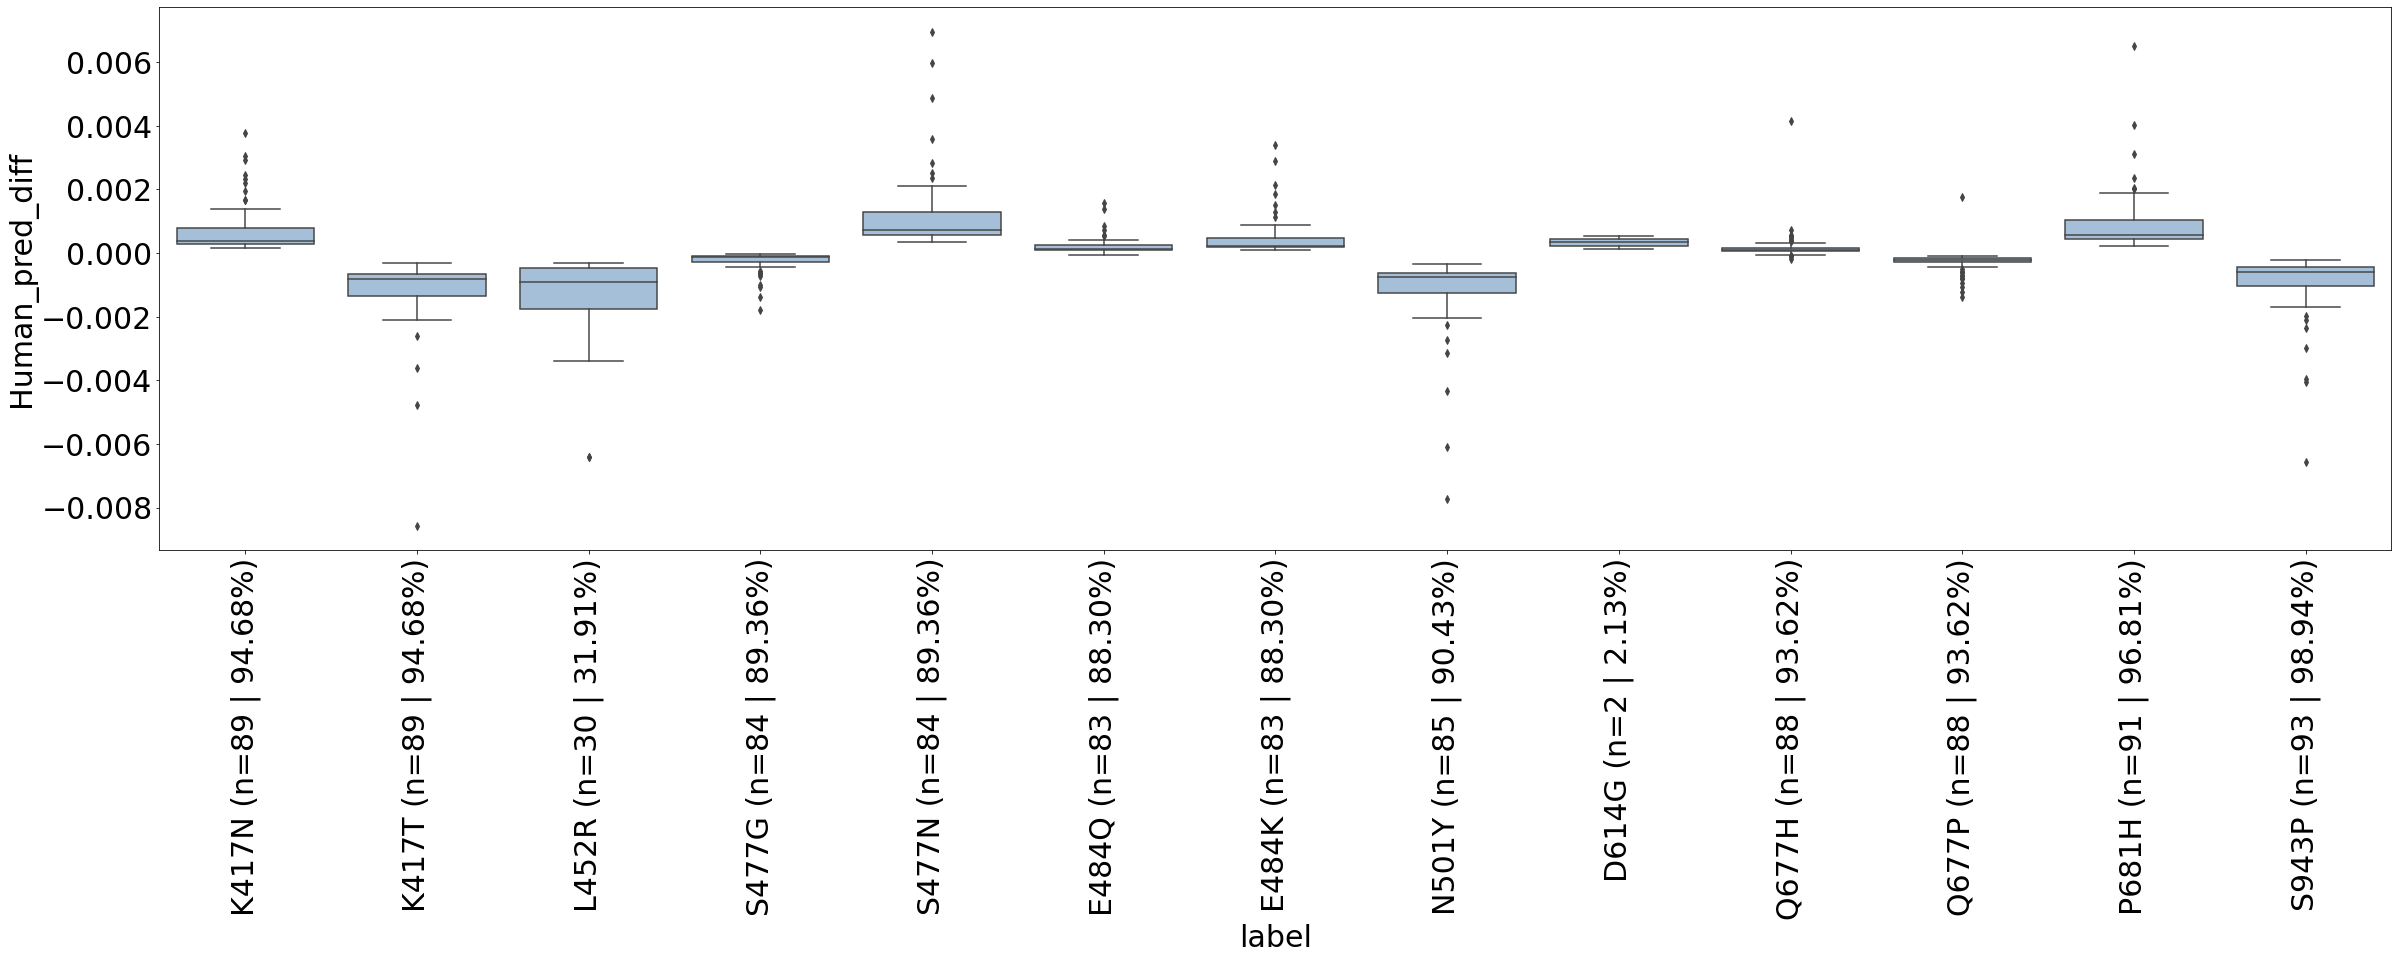

In [69]:
plt.clf()
plt.figure(figsize=(40, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(data=known_mutations_df, x="label", y="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_seq_pos")["label"].unique(),
                 boxprops={"facecolor": (.3, .5, .7, .5)})

ax.tick_params(axis='x', rotation=90)
plt.show()

### Identified and Known Mutations

In [70]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["perturbation_id"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))

identified_mutations = 704
known_mutations = 13
intersection = set()


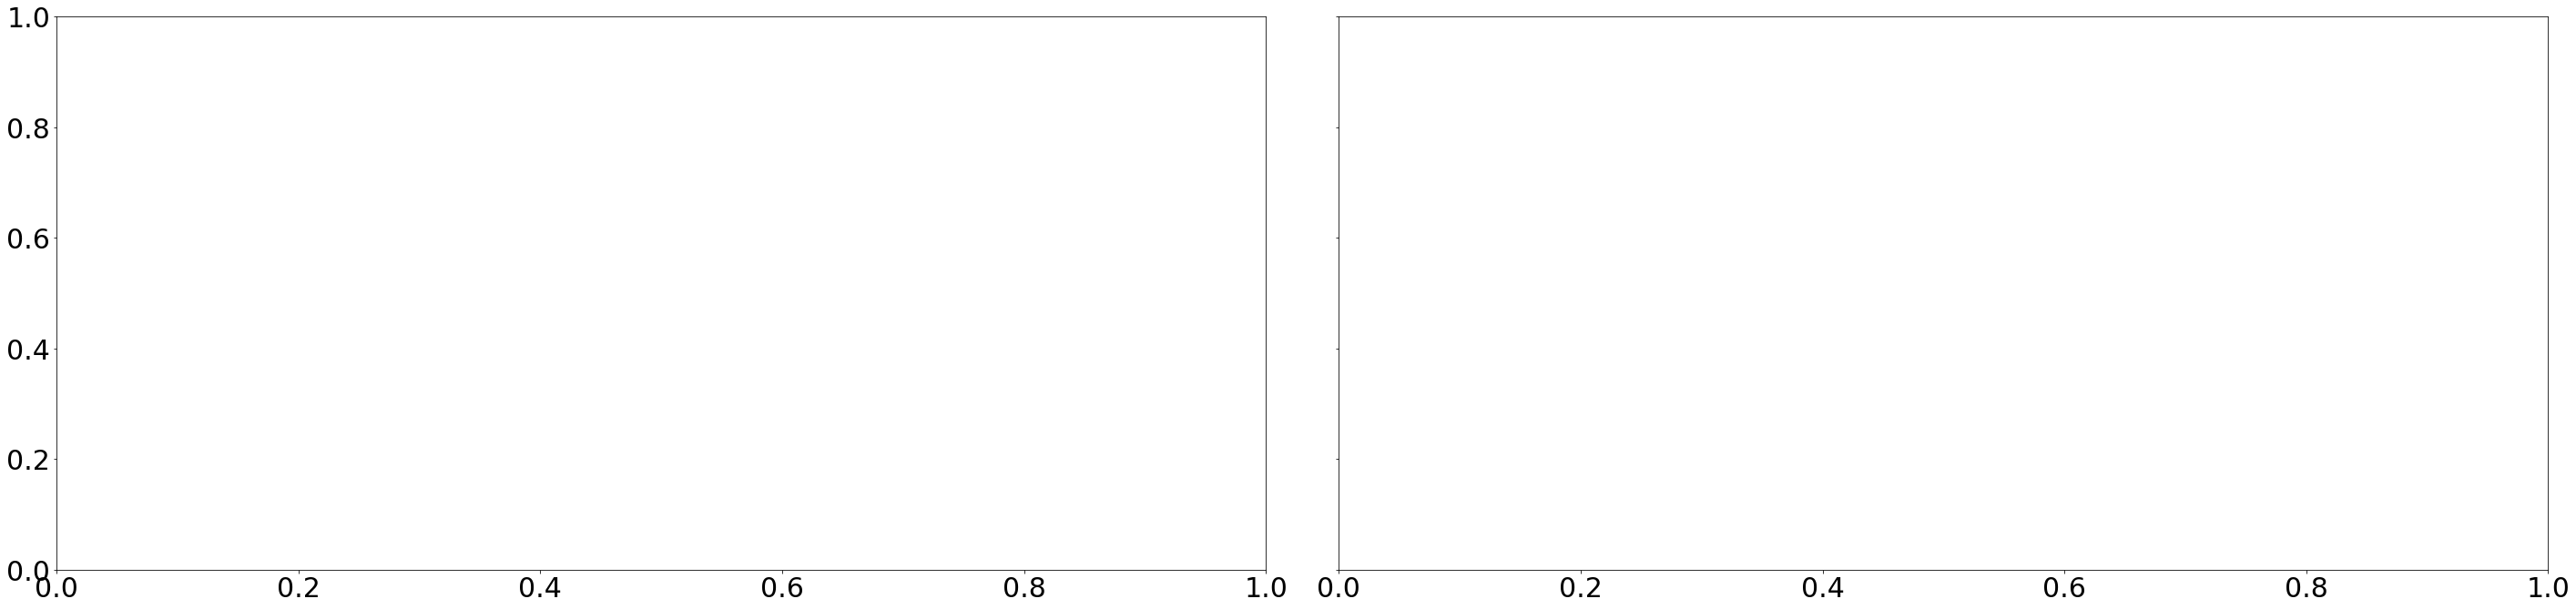

In [47]:

plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(40, 10), sharex=True, sharey=True)

j=0
plot_dfs = []
for i in intersection:
    row = s_mutations_df[s_mutations_df["perturbation_id"] == i]
    plot_df = get_distribution_df(perturbed_output_df, 
                                    orig_token=row["orig_token"].values[0],
                                    perturb_pos=row["pos"].values[0],
                                    perturbation_id=i,
                                    perturbation_id_label=row["label"].values[0])
    sns.kdeplot(data=plot_df, x="Human_pred_diff", hue="type", ax=axs[j], legend=True)
    axs[j].set_title(row["label"].values[0])
    plot_dfs.append(plot_df)
    j += 1
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="30")
plt.tight_layout()
plt.show()


In [48]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.violinplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type")
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

ValueError: No objects to concatenate

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [49]:
plt.clf()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

ax = sns.boxplot(pd.concat(plot_dfs), x="label", y="Human_pred_diff", hue="type", notch=True)
#ax = (data=pd.concat(plot_dfs), x="perturbation_id", y="Human_pred_diff", hue="type", notch=True)
#ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(.8, -0.1), fontsize="30")
plt.tight_layout(pad=.2)
plt.show()

ValueError: No objects to concatenate

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [ ]:
mutation_mean_diff[mutation_mean_diff["mean_Human_pred_diff"] == 0]

In [ ]:
mutation_mean_diff_selected = mutation_mean_diff[(mutation_mean_diff["mean_Human_pred_diff"] > 0.1) | (mutation_mean_diff["mean_Human_pred_diff"] < -0.1)].sort_values("mean_Human_pred_diff", ascending=True)
mutation_mean_diff_selected

In [ ]:
perturbed_output_df[perturbed_output_df["perturbation_id"].isin(mutation_mean_diff_selected["perturbation_id"])]

In [ ]:
plt.clf()
plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

data = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(mutation_mean_diff_selected["perturbation_id"])][["perturbation_id", "Human_pred_diff"]]
ax = sns.boxplot(data=data, y="Human_pred_diff", x="perturbation_id", order=mutation_mean_diff_selected["perturbation_id"])
plt.xticks(rotation=90)
plt.show()